In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
dataset_name = "W13_comb"

In [5]:
# %%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)


In [6]:
# BES_Panel = pd.read_stata(data_subfolder + "BES2015_W10_v0.8.dta")
# BES_Panel.to_msgpack(data_subfolder + "BES2015_W10_v0.8.dta".replace('.dta','.msgpack'))


In [7]:
####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )
try:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
except:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

# BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
# print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

var_type (5173, 8)
BES_reduced_with_na (68625, 2572)


In [8]:
fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

In [9]:
## augment dataset
# pan_dataset_values
# census data
# 

pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    

In [10]:
max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
weights = BES_Panel[list(num_to_weight.values())].copy()

In [42]:
# http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

## SHOULD BE REPLACED WITH pan_dataset_variables reference
pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]


# len()
census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
census_vars.append("leaveHanretty")
census_vars.append("remainHanretty")
census_vars.append("pano")
# ConstituencyType
BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')


BES_census_data (632, 308)


IndexError: single positional indexer is out-of-bounds

In [30]:
import sys, gc

def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def memory_use(locs = locals().items()):
    gc.collect()
    # locals().items()
    for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locs),
                             key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))
memory_use()


           BES_reduced_with_na:   1.3GiB
                     BES_Panel: 410.7MiB
                             _:  81.2MiB
                           _29:  81.2MiB
                     immigDiff:  81.2MiB
                       weights:   7.3MiB
                         immig:   6.8MiB
            pan_dataset_values:   4.2MiB
                      var_type:   2.3MiB
                          mask:   1.3MiB


In [18]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [31]:
def get_base(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
    
    immig_vars = [im_var+x for x in wave_list]

    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

In [26]:
Treatment = "testing"

### focal variable??

In [33]:
var_stub = "partyId"
var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub+"W\d+_No - none",x)]
# "partyIdStrength",
var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
var_list

['partyIdW1_No - none',
 'partyIdW2_No - none',
 'partyIdW3_No - none',
 'partyIdW4_No - none',
 'partyIdW6_No - none',
 'partyIdW7_No - none',
 'partyIdW8_No - none',
 'partyIdW9_No - none',
 'partyIdW10_No - none',
 'partyIdW11_No - none',
 'partyIdW12_No - none',
 'partyIdW13_No - none']

In [34]:
dataset_name

'W13_comb'

In [40]:
var_type

type              pruned  \
id                          -5.0                 NaN   
wt_core_W3                   NaN                 NaN   
wt_core_W4                   NaN                 NaN   
wt_core_W5                   NaN                 NaN   
wt_core_W6                   NaN                 NaN   
wt_core_W7                   NaN                 NaN   
wt_core_W8                   NaN                 NaN   
wt_core_W9                   NaN                 NaN   
wt_core_W1                   NaN                 NaN   
wt_core_W2                   NaN                 NaN   
wt_full_W3                   NaN                 NaN   
wt_full_W1W2W3               NaN                 NaN   
wt_full_W4                   NaN                 NaN   
wt_full_W1W2W3W4             NaN                 NaN   
wt_full_W5                   NaN                 NaN   
wt_full_W1W2W3W4W5           NaN                 NaN   
wt_full_W4W5                 NaN                 NaN   
wt_full_W6                   NaN                 NaN   
wt_full_W1W2W3W4W5W6         NaN                 NaN   
wt_full_W4W5W6               NaN                 NaN   
wt_full_W4W6                 NaN                 NaN   
wt_full_W7                   NaN                 NaN   
wt_full_W8                   NaN                 NaN   
wt_full_W1W2W3W4W5W6W7W8     NaN                 NaN   
wt_full_W7W8                 NaN                 NaN   
wt_full_W9                   NaN                 NaN   
wt_full_W1W2W3W4W5W6W7W8W9   NaN                 NaN   
wt_full_W7W8W9               NaN                 NaN   
wt_full_W10                  NaN                 NaN   
wt_full_W11                  NaN                 NaN   
...                          ...                 ...   
polKnowMerkelW5W7W9          3.0       polKnowMerkel   
polKnowAssadW5W7W9           3.0        polKnowAssad   
polKnowNetanyahuW2W3W4W7W9   3.0    polKnowNetanyahu   
polKnowHollandeW2W3W4W7W9    3.0     polKnowHollande   
polKnowKerryW2W3W4W7W9       3.0        polKnowKerry   
lr_scaleW7W8W9               1.0            lr_scale   
al_scaleW7W8W9               1.0            al_scale   
lr_scaleW6                   1.0            lr_scale   
al_scaleW6                   1.0            al_scale   
lr_scaleW1W2W3W4W5           1.0            lr_scale   
al_scaleW1W2W3W4W5           1.0            al_scale   
lr_scaleW10W11W12            1.0            lr_scale   
al_scaleW10W11W12            1.0            al_scale   
lr_scaleW13                  1.0            lr_scale   
al_scaleW13                  1.0            al_scale   
CampaignDayW8                NaN                 NaN   
CampaignDayW12               NaN                 NaN   
scotRefTurnoutW4_W13         3.0      scotRefTurnout   
scotRefVoteW4_W13            3.0         scotRefVote   
panoW12                      7.0                pano   
panoW13                      7.0                pano   
panoW2                       7.0                pano   
gorW2                       -4.0                 NaN   
panoW3                       7.0                pano   
gorW3                       -4.0                 NaN   
panoW6                       7.0                pano   
gorW6                       -4.0                 NaN   
headHouseholdPast            3.0   headHouseholdPast   
fatherNumEmployees           1.0  fatherNumEmployees   
motherNumEmployees           1.0  motherNumEmployees   

                                                            original_cat_list  \
id                                                                        NaN   
wt_core_W3                                                                NaN   
wt_core_W4                                                                NaN   
wt_core_W5                                                                NaN   
wt_core_W6                                                                NaN   
wt_core_W7                                                           

In [42]:
len( set(var_type[  var_type["type"]==1].index).intersection(BES_Panel.columns) )

4347

In [43]:
len( BES_Panel.columns )

5150

In [45]:
thresh = 0.01 # -> 76 variables
# thresh = 0.05 # -> 65 variables!
# thresh = 0.1 # -> 134 variables
# thresh = 0.5 # -> 134 variables

In [46]:
%%time
diff_feature_candidate_list = []
for focal_var in var_list:
    print(focal_var)
    corr = BES_reduced_with_na.corrwith(BES_reduced_with_na[focal_var])
    ordinal_vars = var_type[ (var_type["type"]==1) ].index
    reduced_ordinal_vars = [x for x in new_old_col_names.keys() if new_old_col_names[x] in ordinal_vars]
    reduced_corr = corr.loc[reduced_ordinal_vars].sort_values()

    high_corr = reduced_corr[ np.logical_or( reduced_corr< reduced_corr.quantile(thresh) ,
                                             reduced_corr> reduced_corr.quantile(1-thresh) ) ]
    diff_feature_candidate_list.extend(list(high_corr.index))

partyIdW1_No - none
partyIdW2_No - none
partyIdW3_No - none
partyIdW4_No - none
partyIdW6_No - none
partyIdW7_No - none
partyIdW8_No - none
partyIdW9_No - none
partyIdW10_No - none
partyIdW11_No - none
partyIdW12_No - none
partyIdW13_No - none
Wall time: 5min 27s


In [47]:
diff_feature_candidate_list

['turnoutUKGeneralW1__Very likely that I will vote',
 'turnoutUKGeneralW3__Very likely that I will vote',
 'turnoutUKGeneralW2__Very likely that I will vote',
 'turnoutUKGeneralW4__Very likely that I will vote',
 'turnoutUKGeneralW10__Very likely that I will vote',
 'turnoutUKGeneralW5__Very likely that I will vote',
 'euroTurnoutW1__Very likely that I will vote',
 'turnoutUKGeneralW7__Very likely that I will vote',
 'turnoutUKGeneralW8__Very likely that I will vote',
 'electionInterestW4__Very interested',
 'dutyToVote2W1__Strongly agree',
 'electionInterestW5__Very interested',
 'polAttentionW1__Pay a great deal of attention',
 'trustMPsW1__A great deal of trust',
 'generalElectionCertaintyW1__Completely certain',
 'turnoutUKGeneralW9__Very likely that I will vote',
 'turnoutUKGeneralW12__Very likely that I will vote',
 'efficacyNoMatterW6__Strongly agree',
 'efficacyNoMatterW4__Strongly agree',
 'partydiffconlabW5__There is not much difference between them',
 'conNoneW4_Yes',
 'labNoneW4_Yes',
 'partyIdStrengthW11__Not very strong',
 'partyIdStrengthW12__Not very strong',
 'partyIdStrengthW13__Not very strong',
 'partyIdStrengthW10__Not very strong',
 'partyIdStrengthW9__Not very strong',
 'partyIdStrengthW8__Not very strong',
 'partyIdStrengthW7__Not very strong',
 'partyIdStrengthW2__Not very strong',
 'partyIdStrengthW3__Not very strong',
 'partyIdStrengthW6__Not very strong',
 'partyIdStrengthW4__Not very strong',
 'partyIdStrengthW1__Not very strong',
 'turnoutUKGeneralW2__Very likely that I will vote',
 'turnoutUKGeneralW1__Very likely that I will vote',
 'turnoutUKGeneralW3__Very likely that I will vote',
 'turnoutUKGeneralW4__Very likely that I will vote',
 'turnoutUKGeneralW5__Very likely that I will vote',
 'turnoutUKGeneralW10__Very likely that I will vote',
 'turnoutUKGeneralW7__Very likely that I will vote',
 'turnoutUKGeneralW8__Very likely that I will vote',
 'electionInterestW4__Very interested',
 'euroTurnoutW1__Very likely that I will vote',
 'polAttentionW2__Pay a great deal of attention',
 'electionInterestW5__Very interested',
 'dutyToVote2W2__Strongly agree',
 'polAttentionW4__Pay a great deal of attention',
 'generalElectionCertaintyW4__Completely certain',
 'polAttentionW3__Pay a great deal of attention',
 'polAttentionW1__Pay a great deal of attention',
 'labNoneW6_Yes',
 'partydiffconlabW5__There is not much difference between them',
 'efficacyNoMatterW4__Strongly agree',
 'conNoneW4_Yes',
 'partyIdStrengthW13__Not very strong',
 'labNoneW4_Yes',
 'partyIdStrengthW9__Not very strong',
 'partyIdStrengthW11__Not very strong',
 'partyIdStrengthW10__Not very strong',
 'partyIdStrengthW12__Not very strong',
 'partyIdStrengthW7__Not very strong',
 'partyIdStrengthW8__Not very strong',
 'partyIdStrengthW3__Not very strong',
 'partyIdStrengthW2__Not very strong',
 'partyIdStrengthW6__Not very strong',
 'partyIdStrengthW1__Not very strong',
 'partyIdStrengthW4__Not very strong',
 'turnoutUKGeneralW3__Very likely that I will vote',
 'turnoutUKGeneralW1__Very likely that I will vote',
 'turnoutUKGeneralW2__Very likely that I will vote',
 'turnoutUKGeneralW4__Very likely that I will vote',
 'turnoutUKGeneralW10__Very likely that I will vote',
 'turnoutUKGeneralW5__Very likely that I will vote',
 'turnoutUKGeneralW7__Very likely that I will vote',
 'turnoutUKGeneralW8__Very likely that I will vote',
 'electionInterestW4__Very interested',
 'euroTurnoutW1__Very likely that I will vote',
 'electionInterestW5__Very interested',
 'polAttentionW3__Pay a great deal of attention',
 'polAttentionW4__Pay a great deal of attention',
 'generalElectionCertaintyW4__Completely certain',
 'turnoutUKGeneralW9__Very likely that I will vote',
 'generalElectionCertaintyW3__Completely certain',
 'polAttentionW10__Pay a great deal of attention',
 'efficacyNoMatterW4__Strongly agree',
 'conNoneW6_Yes',
 'labNoneW6_Yes',
 'conNoneW4_Yes',
 'partyIdStrengthW13__Not very strong',
 'partyIdStrengthW11__Not very strong',
 'labNoneW4_Yes'

In [32]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
             "ukCoopMovement",
             "likeLab", "likeCon", "decidedVote", "leftRight", 
             "partyMember", "trustMPs", "electionInterest", "partyIdStrength"]

# "pid", "infoSource", "ptv",
# im_var = "immigCultural"
# imvar_list = ["ptvLab"]

# likeCon, likeLab, pid???, decidedVote, infoSource???, leftRight, ptv???, partyMember, trustMPs, electionInterest
# dutyToVote2

imvar_list.extend(["partyId"])

num = 0
for im_var in imvar_list:
    print(im_var)
    immig, mask = get_base(im_var,noNans = False)
    #immig.columns = ["Delta_"+x for x in immig.columns]
    
    waves_tmp = [re.search("(W\d+)",x).groups()[0] for x in immig.columns]
    replace_wave = ["("+waves_tmp[a]+"->"+waves_tmp[a+1]+")" for a,b in enumerate(immig.columns[1:])]
    temp = [immig.columns[0]]
    temp.extend([re.sub("W\d+",replace_wave[i],x) for i,x in enumerate(immig.columns[1:])])
    immig.columns = temp   
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1

immigEcon
immigCultural
immigSelf
immigrationLevel
immigContributeTake
immigrantsWelfareState
controlImmig
effectsEUImmigration
euPriorityBalance
changeImmig
changeImmigLab
govtHandleImmig
labHandleImmig
asylumMore
euMore
noneuMore
studentsMore
familiesMore
ukCoopMovement
likeLab
likeCon
decidedVote
leftRight
partyMember
trustMPs
electionInterest
partyIdStrength
partyId


['immigEconW1']

In [22]:
# lr_pos =  [x for x in BES_reduced_with_na.columns if re.match("lrCon|lrLab",x)]
# lr_pos.remove('lrConW10__Right')
# lr_pos

In [23]:
# immigDiff

In [24]:
# immigDiff = BES_reduced_with_na[lr_pos].diff(axis=1)[lr_pos[1::2]]

In [25]:
# lrLab-lrCon

In [27]:
var_stub = "partyId"
var_list = [x for x in BES_reduced_with_na.columns if re.match(var_stub+"W\d+_No - none",x)]
# "partyIdStrength",
var_stub_list = ["partyId", "partyIdSqueeze",  "generalElectionVote", "ashcroft", "generalElectionCertainty"]
# base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
var_list

['partyIdW1_No - none',
 'partyIdW2_No - none',
 'partyIdW3_No - none',
 'partyIdW4_No - none',
 'partyIdW6_No - none',
 'partyIdW7_No - none',
 'partyIdW8_No - none',
 'partyIdW9_No - none',
 'partyIdW10_No - none',
 'partyIdW11_No - none',
 'partyIdW12_No - none',
 'partyIdW13_No - none']

In [28]:
party_id_none_delta = BES_reduced_with_na[var_list].astype('float').diff(axis=1).drop(var_list[0],axis=1)
party_id_none_delta
var_list = var_list[1:]
var_list


['partyIdW2_No - none',
 'partyIdW3_No - none',
 'partyIdW4_No - none',
 'partyIdW6_No - none',
 'partyIdW7_No - none',
 'partyIdW8_No - none',
 'partyIdW9_No - none',
 'partyIdW10_No - none',
 'partyIdW11_No - none',
 'partyIdW12_No - none',
 'partyIdW13_No - none']

In [29]:
# var_list = immigDiff.columns
# var_stub_list = ['lrLab','lrCon']

In [30]:
# var_list.remove('partydiffconlabW5__There is not much difference between them')
# var_list = var_list[-2:]

partyIdW2_No - none 2
missing vals in sample weights: 38414
[0]	validation_0-rmse:0.547879
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.530486
[2]	validation_0-rmse:0.513919
[3]	validation_0-rmse:0.498165
[4]	validation_0-rmse:0.483144
[5]	validation_0-rmse:0.468859
[6]	validation_0-rmse:0.455341
[7]	validation_0-rmse:0.442441
[8]	validation_0-rmse:0.430256
[9]	validation_0-rmse:0.418748
[10]	validation_0-rmse:0.407783
[11]	validation_0-rmse:0.397363
[12]	validation_0-rmse:0.387547
[13]	validation_0-rmse:0.378272
[14]	validation_0-rmse:0.369561
[15]	validation_0-rmse:0.361358
[16]	validation_0-rmse:0.353608
[17]	validation_0-rmse:0.346333
[18]	validation_0-rmse:0.33948
[19]	validation_0-rmse:0.332952
MSE: 0.11, MAE: 0.27, EV: 0.03, R2: -0.79


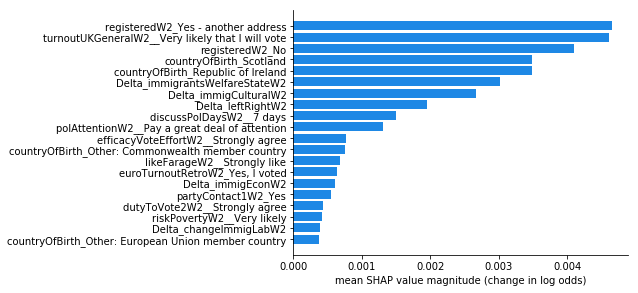

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


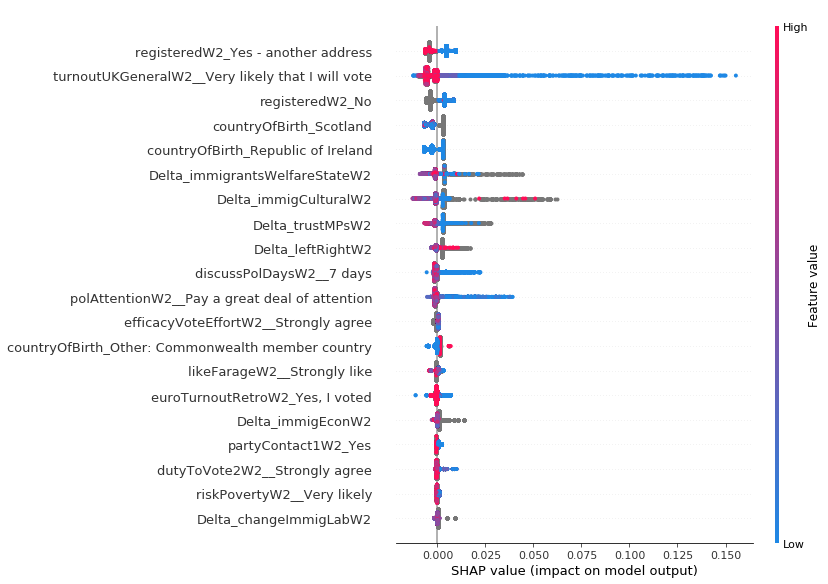

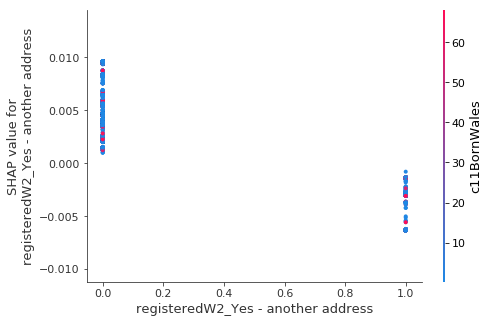

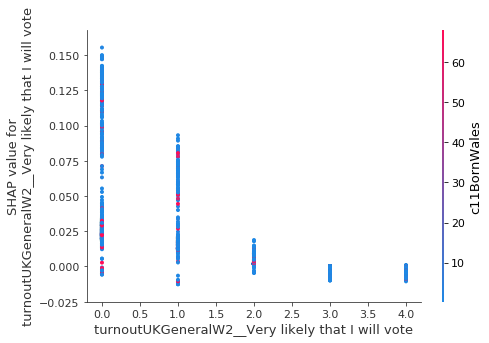

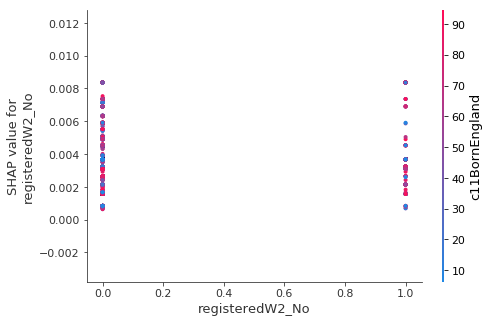

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


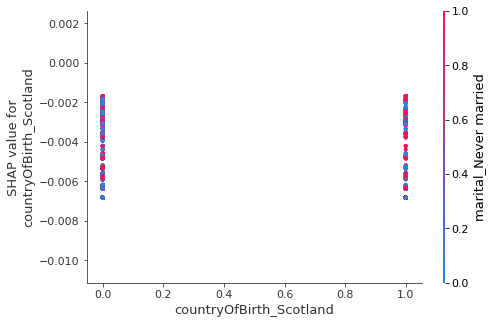

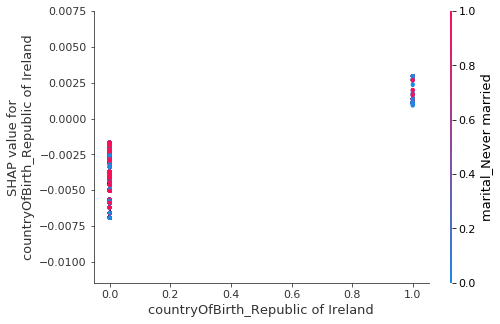

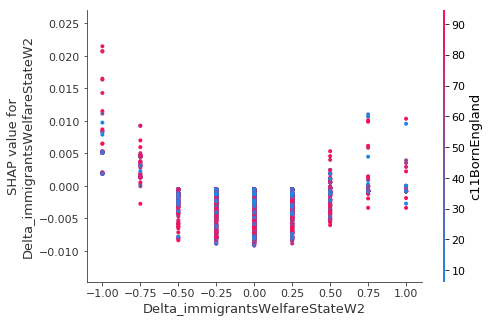

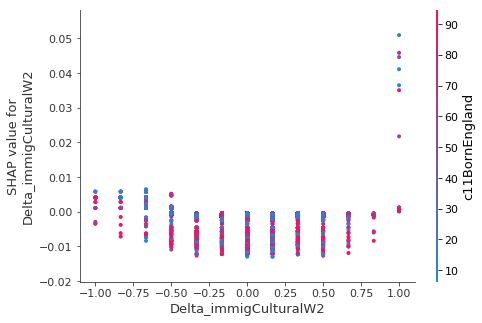

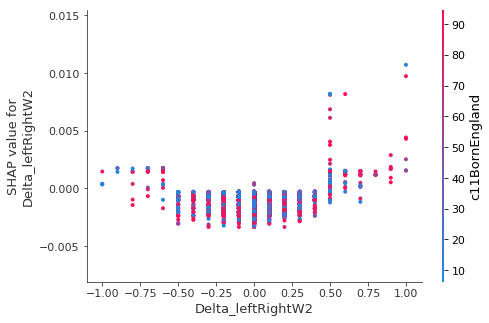

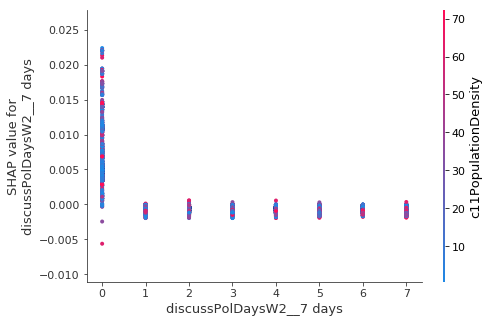

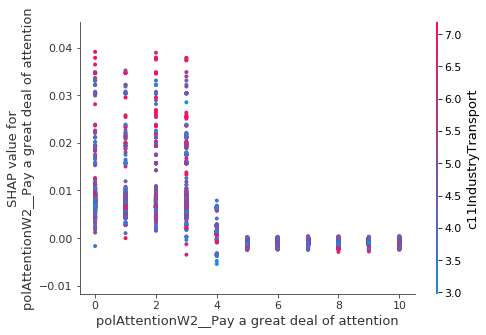

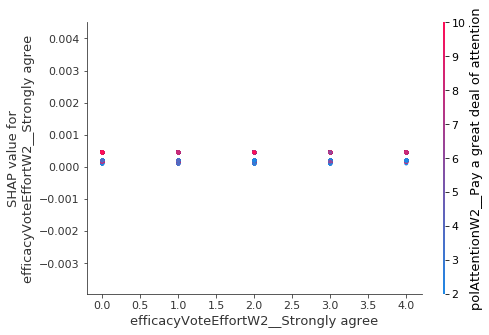

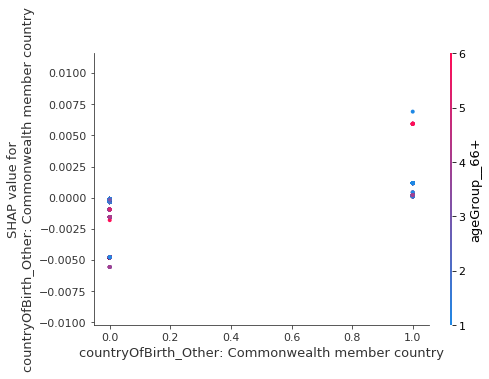

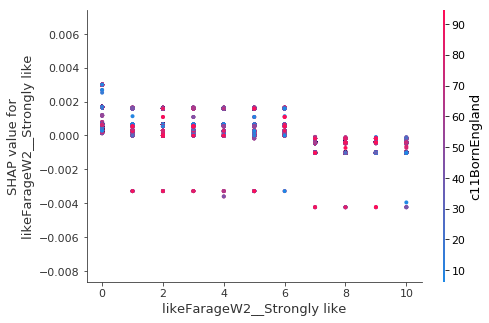

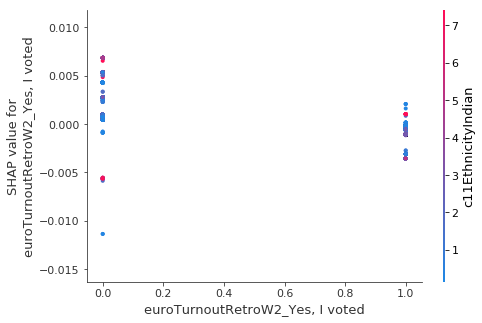

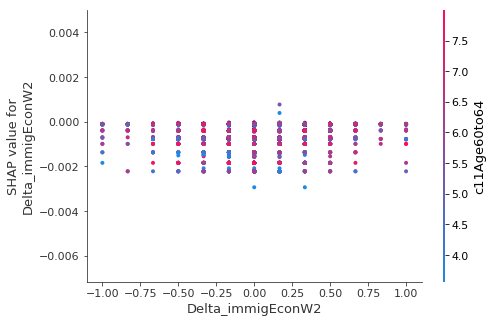

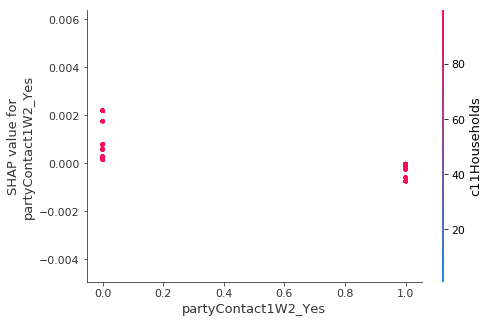

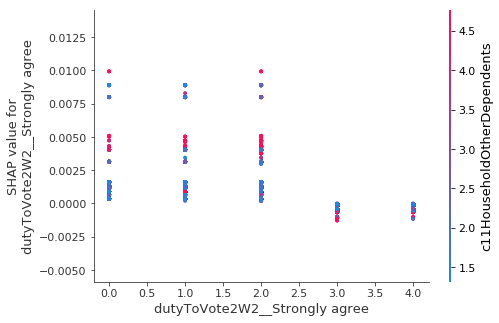

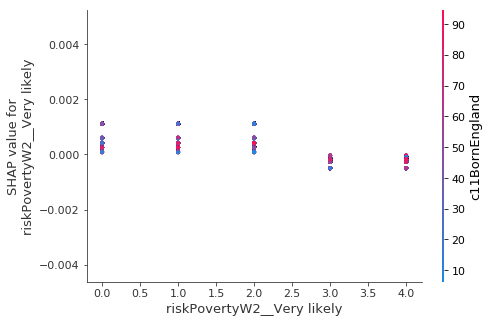

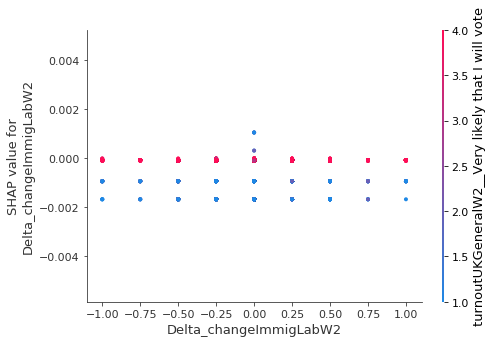

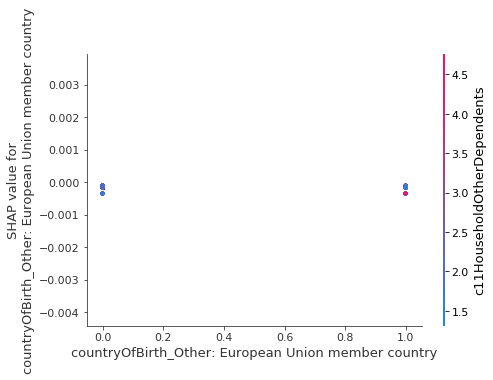

partyIdW3_No - none 3
missing vals in sample weights: 40786
[0]	validation_0-rmse:0.54315
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.52591
[2]	validation_0-rmse:0.509423
[3]	validation_0-rmse:0.493734
[4]	validation_0-rmse:0.478834
[5]	validation_0-rmse:0.464749
[6]	validation_0-rmse:0.451315
[7]	validation_0-rmse:0.438528
[8]	validation_0-rmse:0.426386
[9]	validation_0-rmse:0.414914
[10]	validation_0-rmse:0.404048
[11]	validation_0-rmse:0.393847
[12]	validation_0-rmse:0.384202
[13]	validation_0-rmse:0.375053
[14]	validation_0-rmse:0.366417
[15]	validation_0-rmse:0.35836
[16]	validation_0-rmse:0.350703
[17]	validation_0-rmse:0.343487
[18]	validation_0-rmse:0.336686
[19]	validation_0-rmse:0.3303
MSE: 0.11, MAE: 0.27, EV: 0.06, R2: -0.72


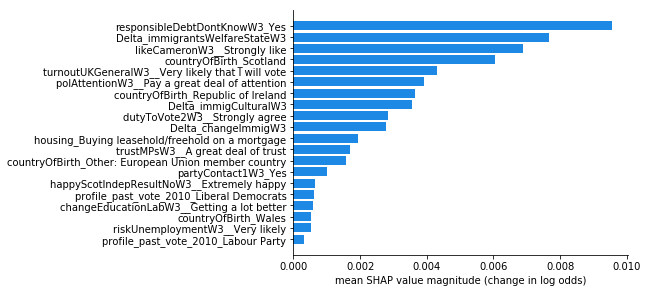

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


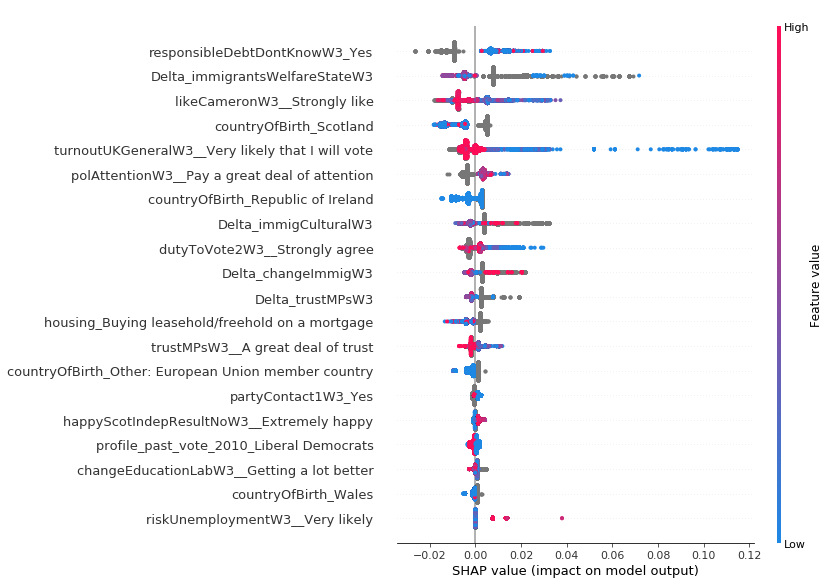

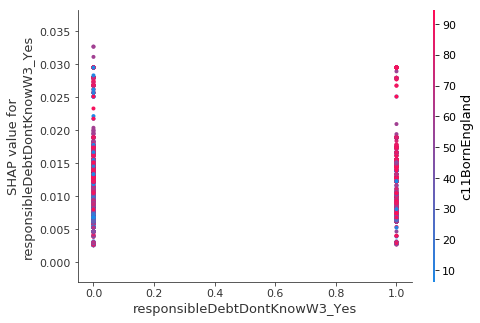

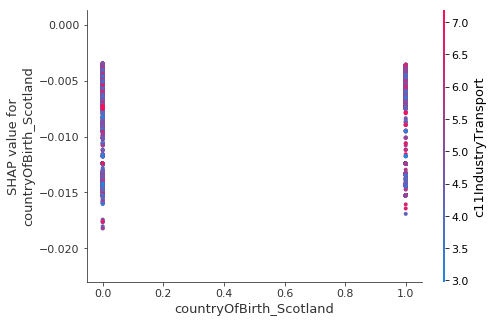

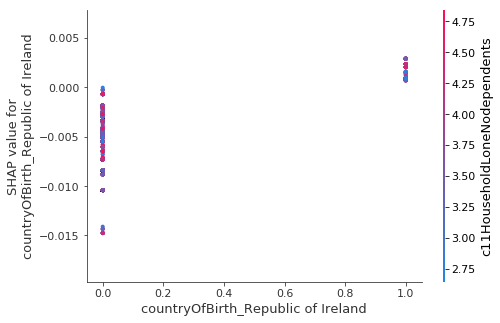

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


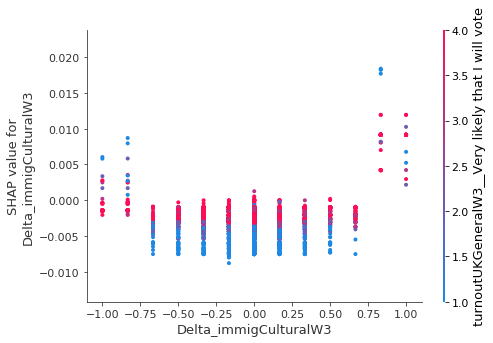

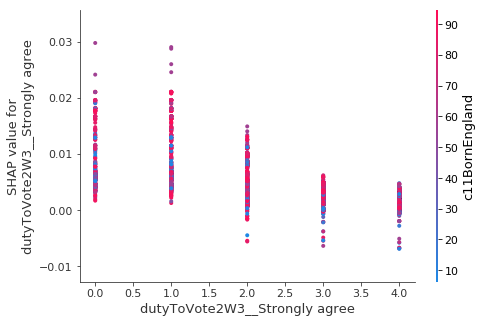

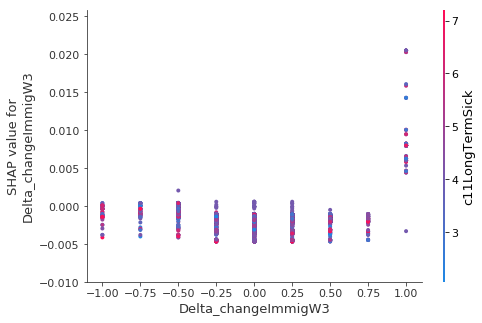

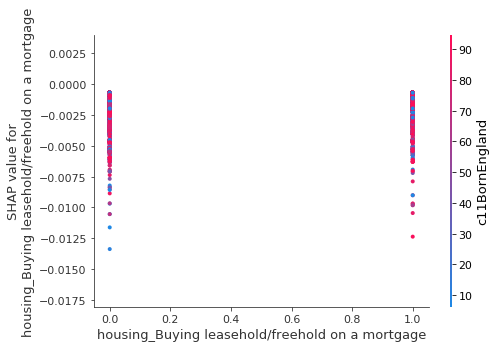

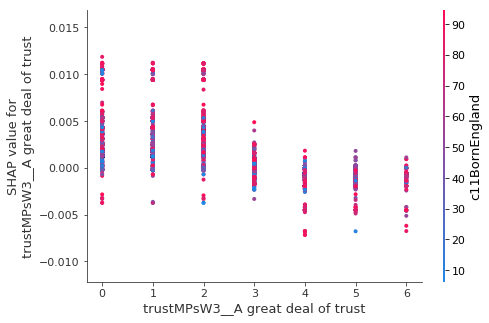

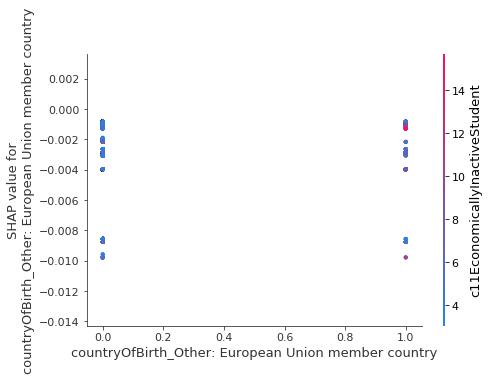

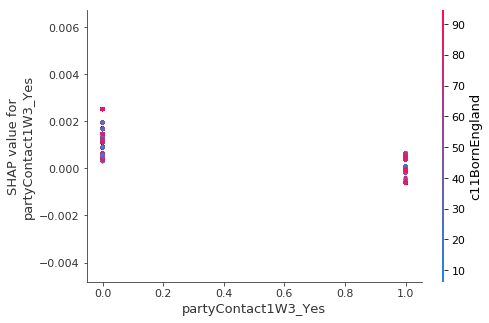

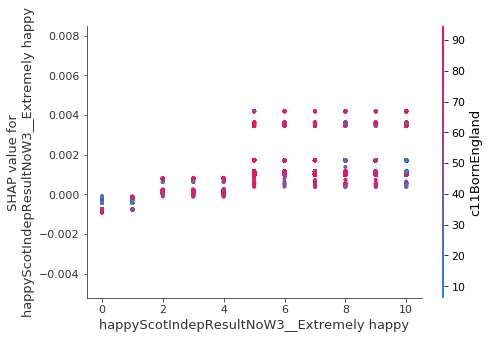

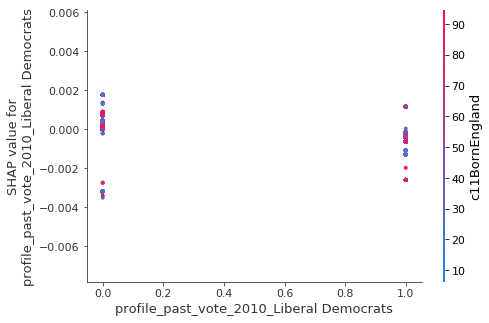

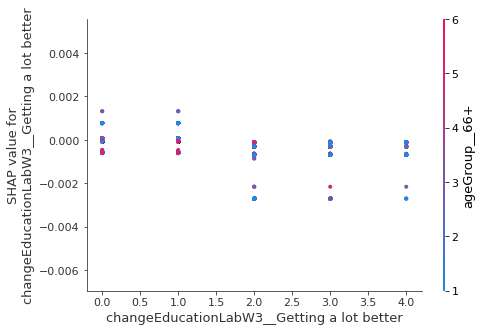

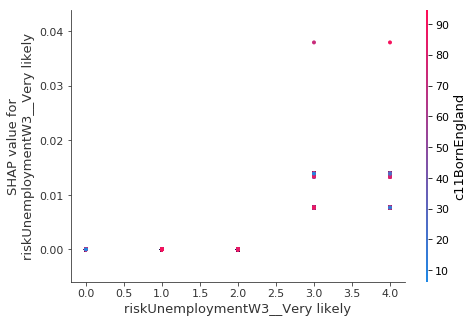

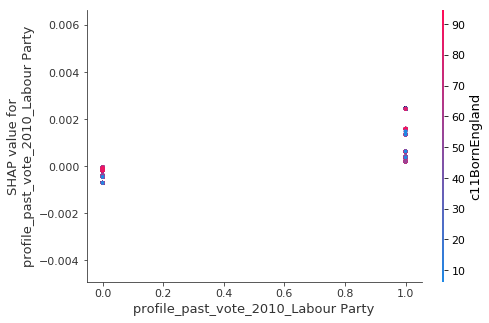

partyIdW4_No - none 4
missing vals in sample weights: 37297
[0]	validation_0-rmse:0.539195
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.522551
[2]	validation_0-rmse:0.506819
[3]	validation_0-rmse:0.491831
[4]	validation_0-rmse:0.477622
[5]	validation_0-rmse:0.46419
[6]	validation_0-rmse:0.451439
[7]	validation_0-rmse:0.439312
[8]	validation_0-rmse:0.427817
[9]	validation_0-rmse:0.416927
[10]	validation_0-rmse:0.406725
[11]	validation_0-rmse:0.397044
[12]	validation_0-rmse:0.387969
[13]	validation_0-rmse:0.37939
[14]	validation_0-rmse:0.371343
[15]	validation_0-rmse:0.36373
[16]	validation_0-rmse:0.356584
[17]	validation_0-rmse:0.349861
[18]	validation_0-rmse:0.343528
[19]	validation_0-rmse:0.337587
MSE: 0.11, MAE: 0.28, EV: 0.05, R2: -0.59


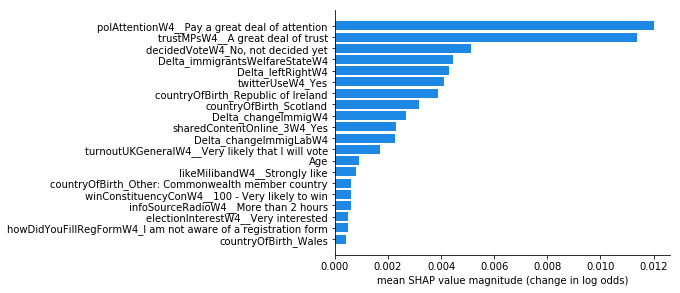

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


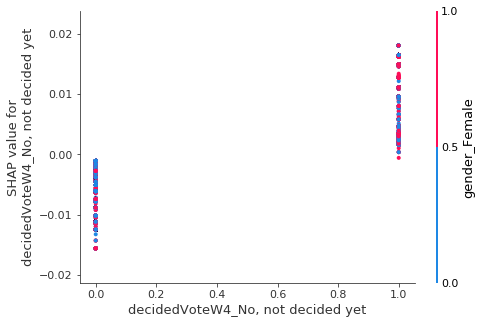

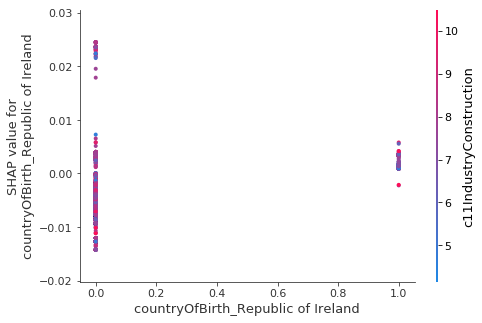

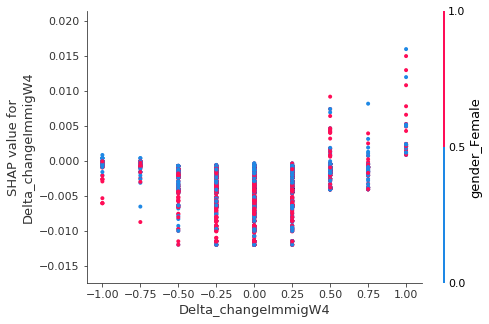

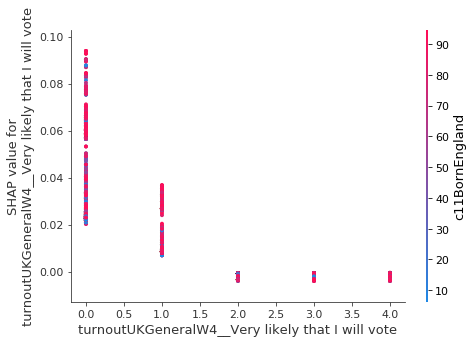

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


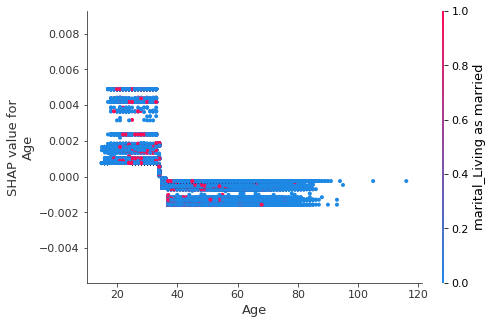

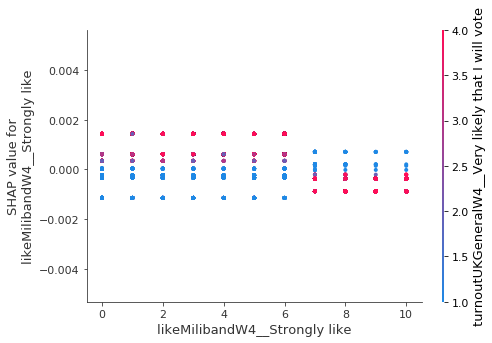

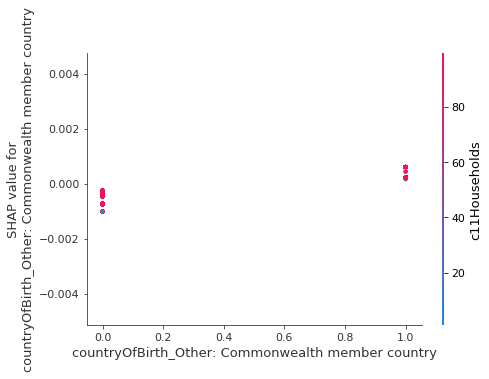

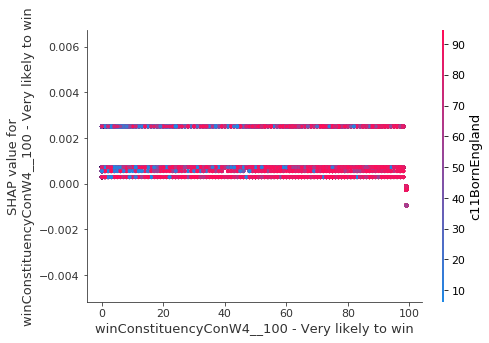

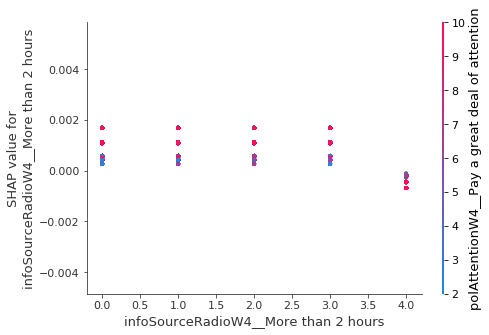

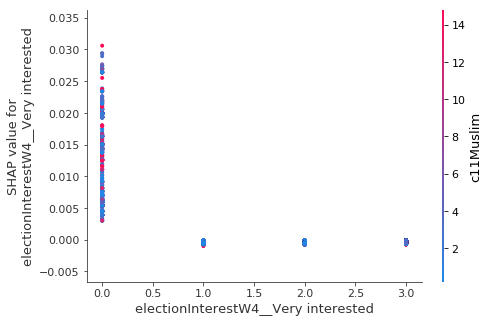

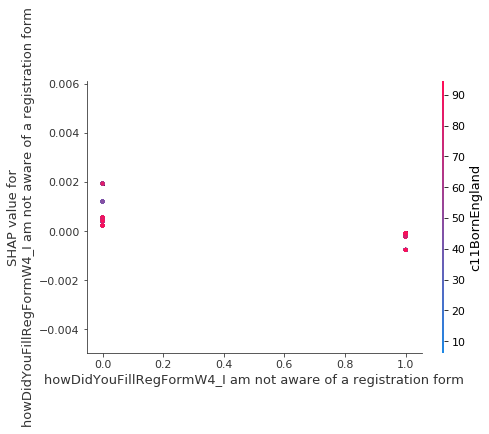

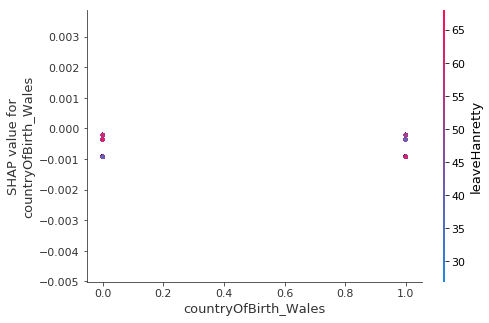

partyIdW6_No - none 6
missing vals in sample weights: 38552
[0]	validation_0-rmse:0.553435
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.536029
[2]	validation_0-rmse:0.519387
[3]	validation_0-rmse:0.503617
[4]	validation_0-rmse:0.488601
[5]	validation_0-rmse:0.47428
[6]	validation_0-rmse:0.460742
[7]	validation_0-rmse:0.447939
[8]	validation_0-rmse:0.435815
[9]	validation_0-rmse:0.424365
[10]	validation_0-rmse:0.41338
[11]	validation_0-rmse:0.403054
[12]	validation_0-rmse:0.393367
[13]	validation_0-rmse:0.384233
[14]	validation_0-rmse:0.375504
[15]	validation_0-rmse:0.367291
[16]	validation_0-rmse:0.359583
[17]	validation_0-rmse:0.352221
[18]	validation_0-rmse:0.345324
[19]	validation_0-rmse:0.338874
MSE: 0.11, MAE: 0.27, EV: 0.01, R2: -0.80


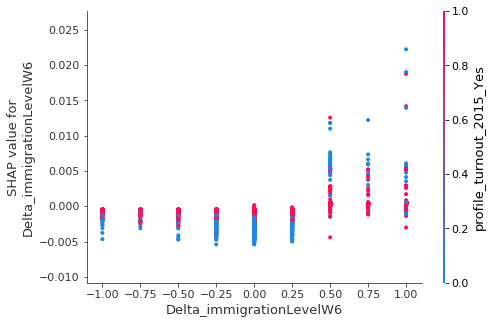

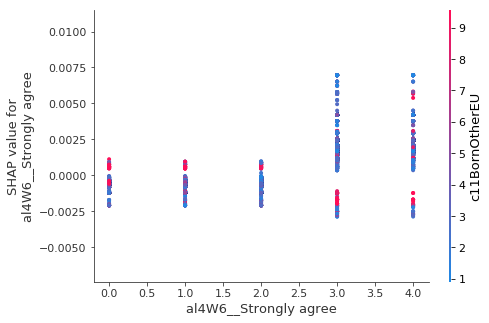

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


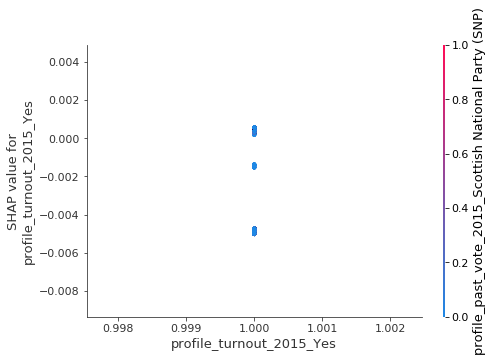

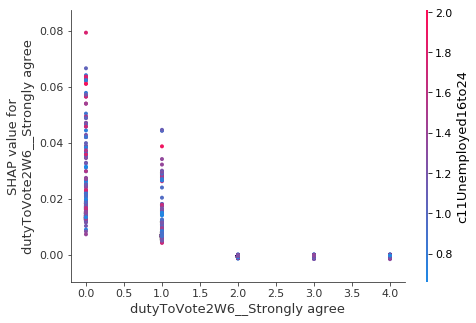

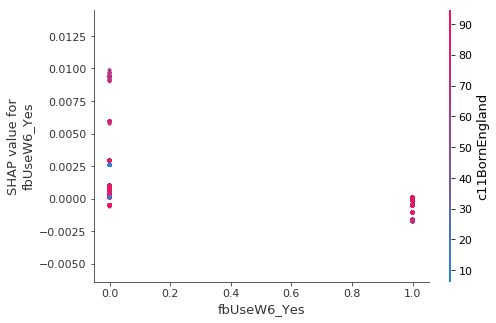

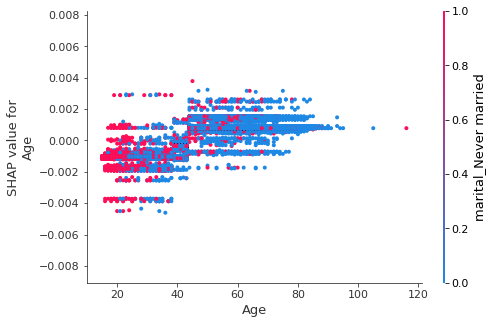

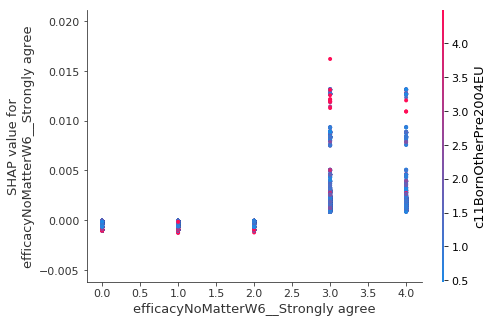

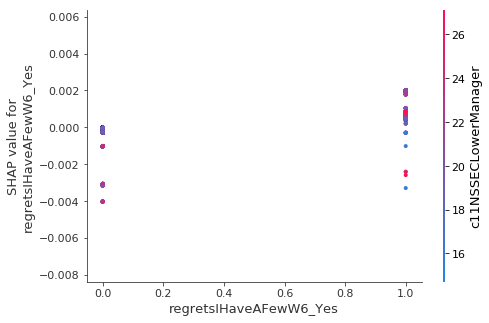

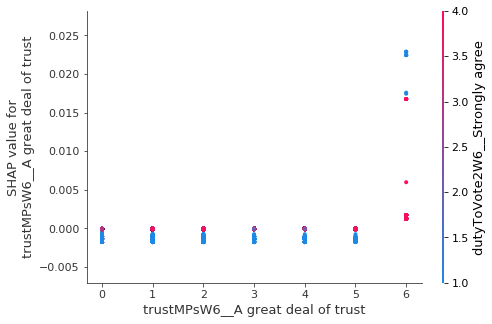

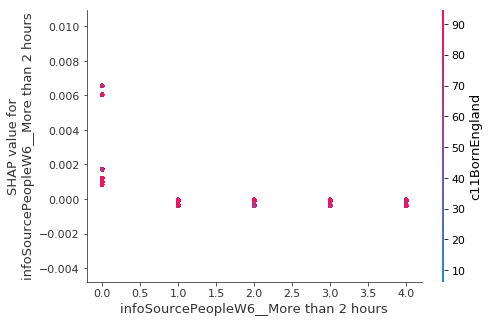

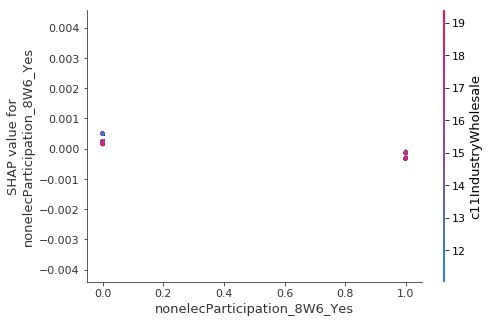

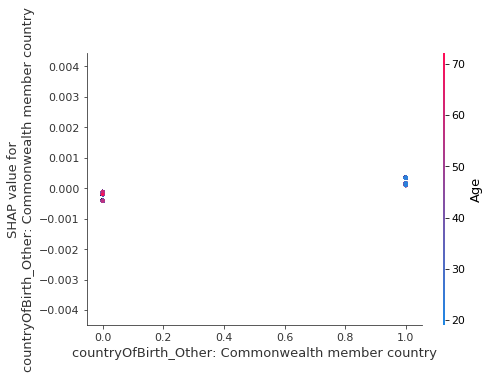

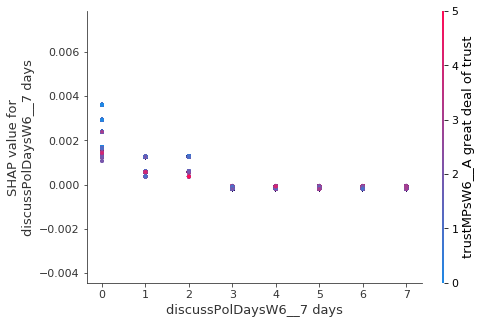

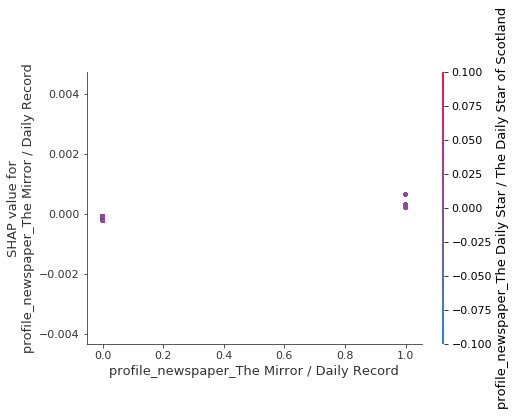

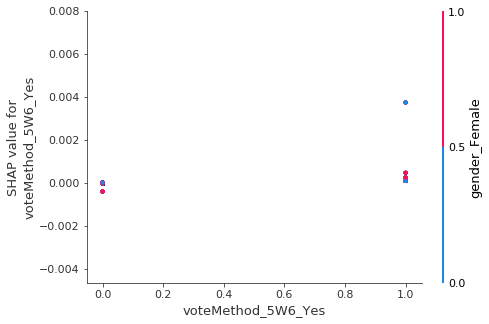

partyIdW7_No - none 7
missing vals in sample weights: 37730
[0]	validation_0-rmse:0.548917
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.532145
[2]	validation_0-rmse:0.516149
[3]	validation_0-rmse:0.501118
[4]	validation_0-rmse:0.486746
[5]	validation_0-rmse:0.473139
[6]	validation_0-rmse:0.460263
[7]	validation_0-rmse:0.448036
[8]	validation_0-rmse:0.436419
[9]	validation_0-rmse:0.425474
[10]	validation_0-rmse:0.415138
[11]	validation_0-rmse:0.405442
[12]	validation_0-rmse:0.396295
[13]	validation_0-rmse:0.387714
[14]	validation_0-rmse:0.379586
[15]	validation_0-rmse:0.371923
[16]	validation_0-rmse:0.364747
[17]	validation_0-rmse:0.35792
[18]	validation_0-rmse:0.351509
[19]	validation_0-rmse:0.345521
MSE: 0.12, MAE: 0.28, EV: 0.07, R2: -0.52


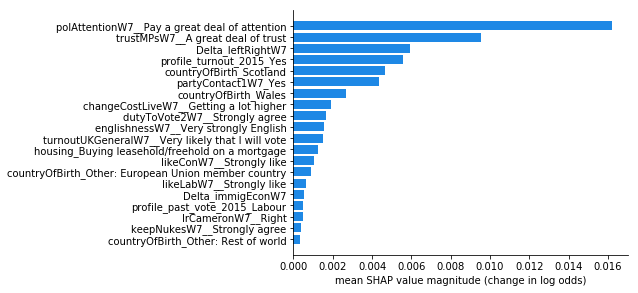

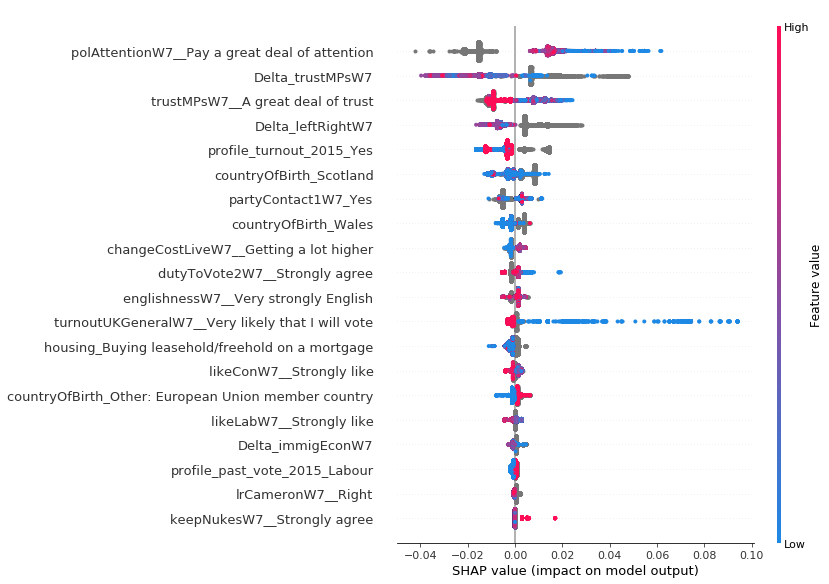

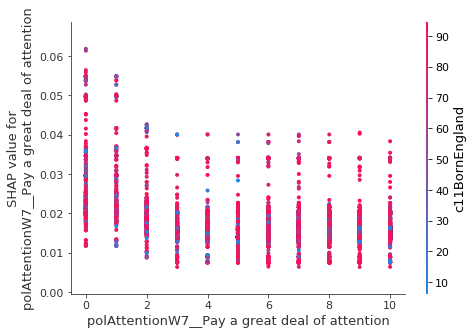

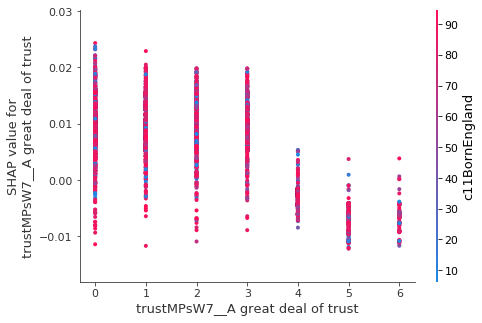

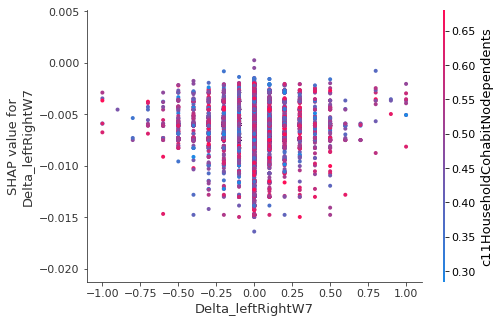

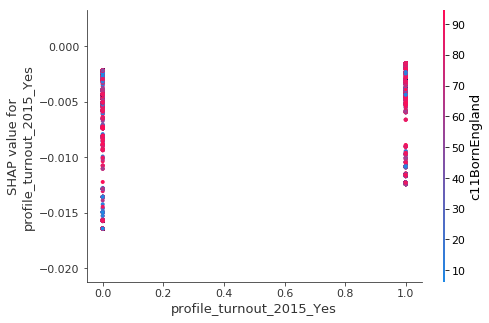

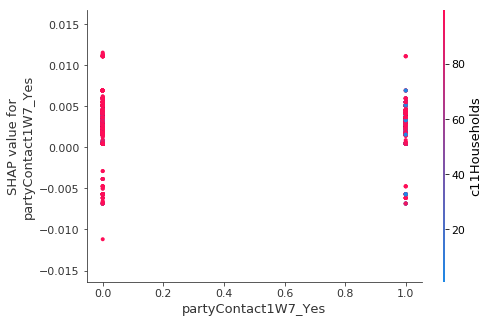

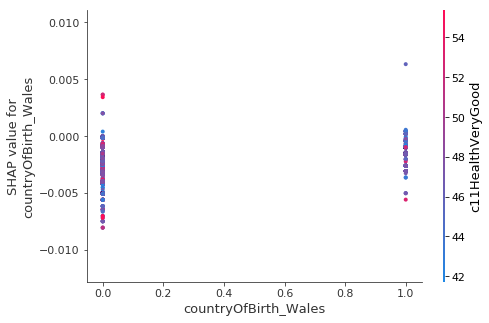

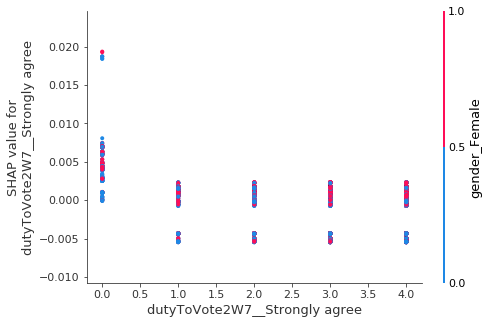

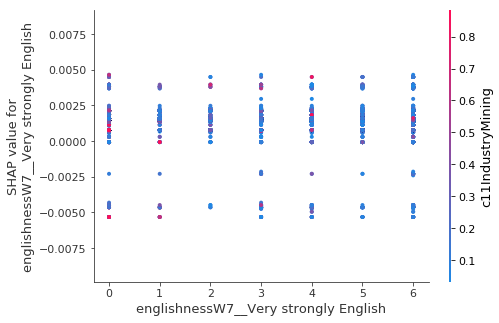

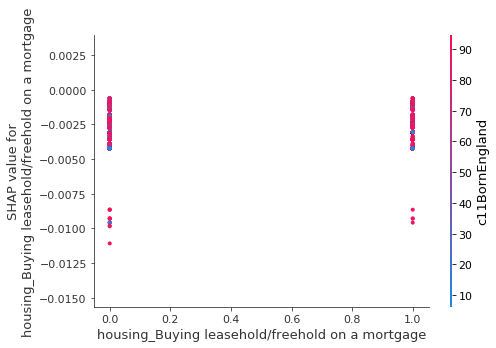

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


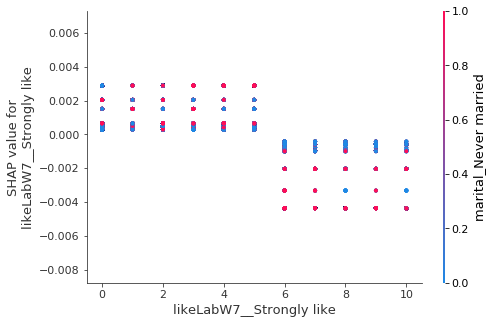

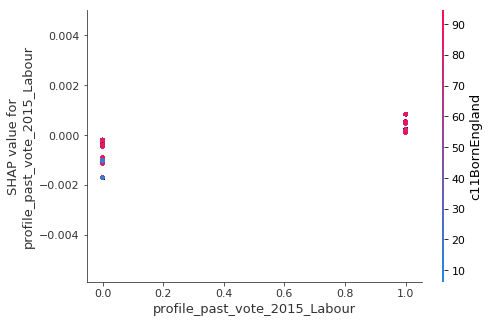

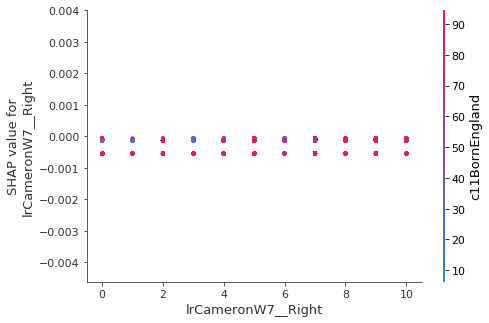

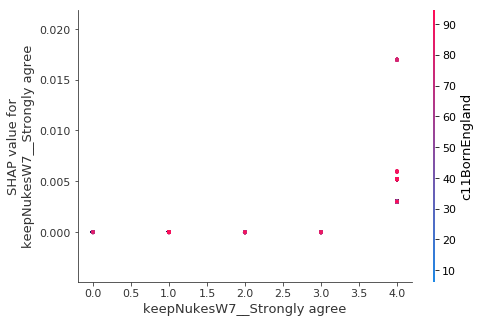

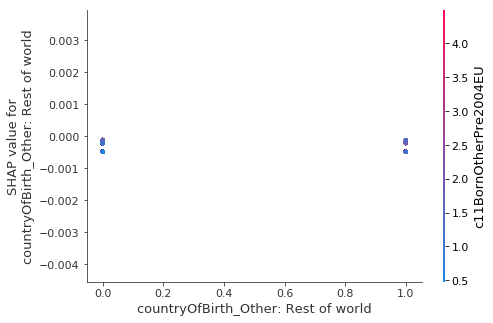

partyIdW8_No - none 8
missing vals in sample weights: 35123
[0]	validation_0-rmse:0.543216
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.526396
[2]	validation_0-rmse:0.510327
[3]	validation_0-rmse:0.495146
[4]	validation_0-rmse:0.480672
[5]	validation_0-rmse:0.466886
[6]	validation_0-rmse:0.453869
[7]	validation_0-rmse:0.441539
[8]	validation_0-rmse:0.429838
[9]	validation_0-rmse:0.418765
[10]	validation_0-rmse:0.40825
[11]	validation_0-rmse:0.398389
[12]	validation_0-rmse:0.38902
[13]	validation_0-rmse:0.380168
[14]	validation_0-rmse:0.371765
[15]	validation_0-rmse:0.363931
[16]	validation_0-rmse:0.356593
[17]	validation_0-rmse:0.349636
[18]	validation_0-rmse:0.34307
[19]	validation_0-rmse:0.336882
MSE: 0.11, MAE: 0.27, EV: 0.06, R2: -0.64


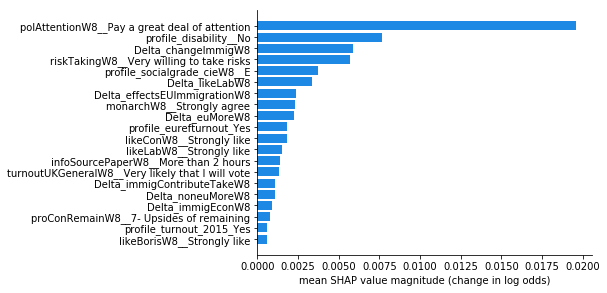

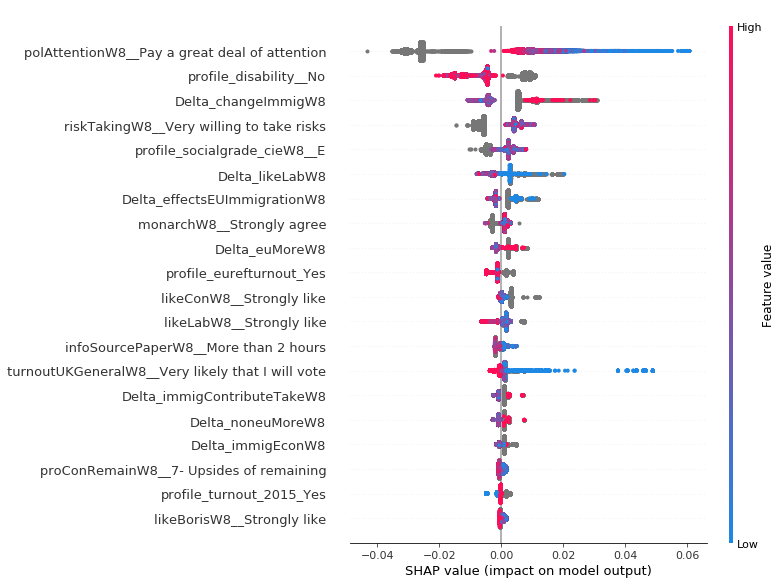

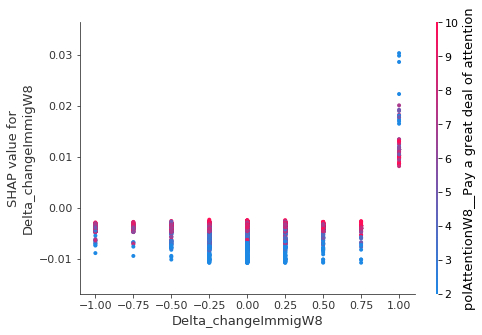

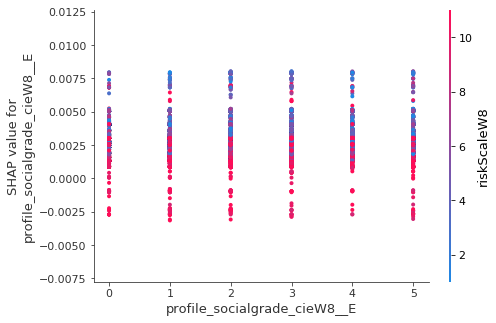

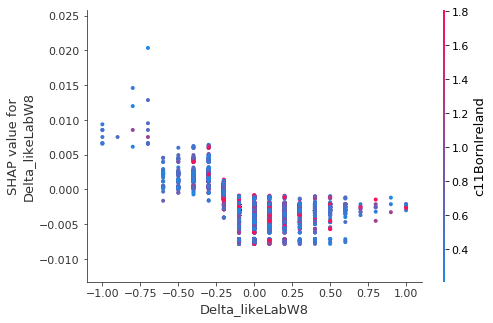

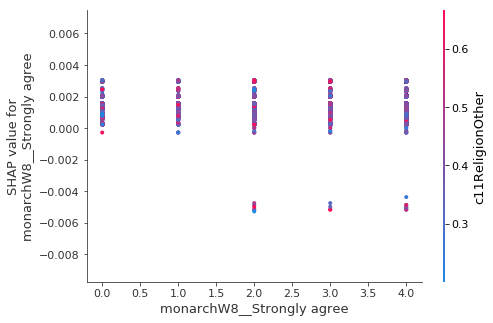

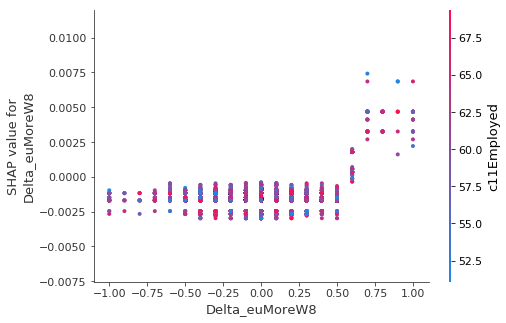

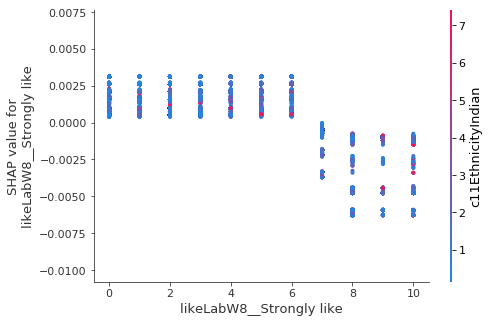

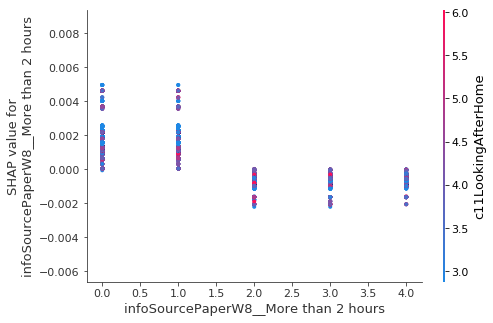

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


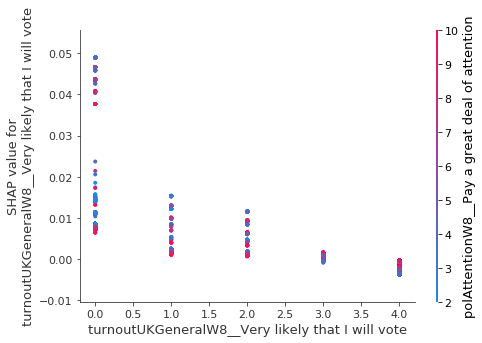

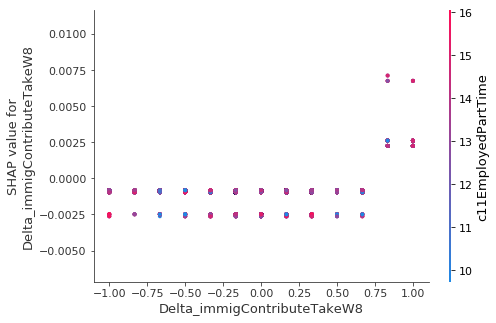

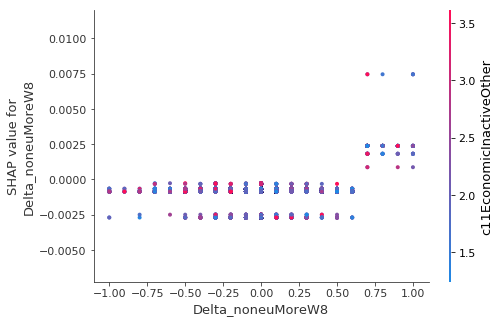

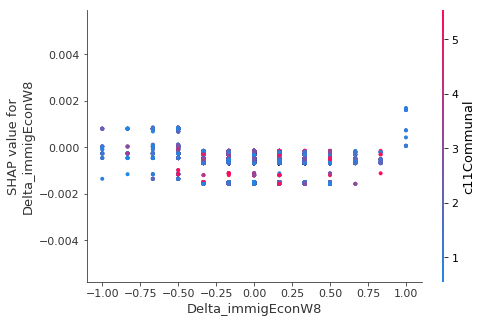

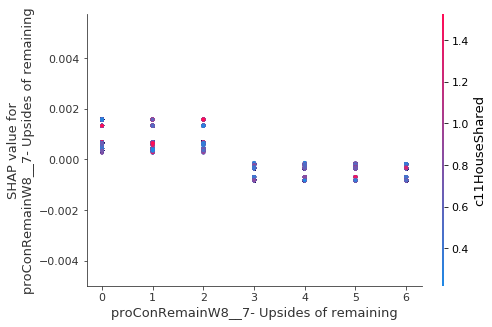

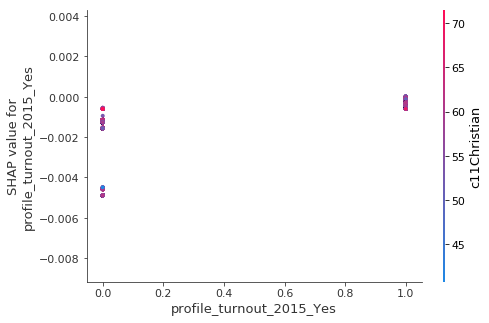

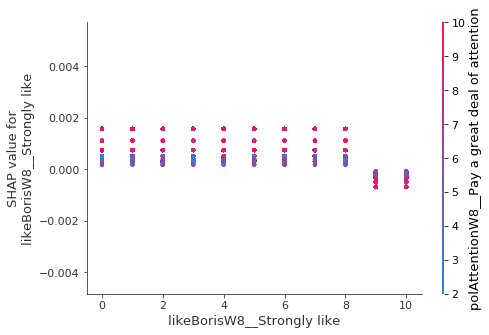

partyIdW9_No - none 9
missing vals in sample weights: 38589
[0]	validation_0-rmse:0.542898
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.525446
[2]	validation_0-rmse:0.508821
[3]	validation_0-rmse:0.493025
[4]	validation_0-rmse:0.478008
[5]	validation_0-rmse:0.463747
[6]	validation_0-rmse:0.4502
[7]	validation_0-rmse:0.437325
[8]	validation_0-rmse:0.425116
[9]	validation_0-rmse:0.413516
[10]	validation_0-rmse:0.402584
[11]	validation_0-rmse:0.39219
[12]	validation_0-rmse:0.382317
[13]	validation_0-rmse:0.373044
[14]	validation_0-rmse:0.364317
[15]	validation_0-rmse:0.356075
[16]	validation_0-rmse:0.348334
[17]	validation_0-rmse:0.340961
[18]	validation_0-rmse:0.334014
[19]	validation_0-rmse:0.327451
MSE: 0.11, MAE: 0.26, EV: 0.03, R2: -0.84


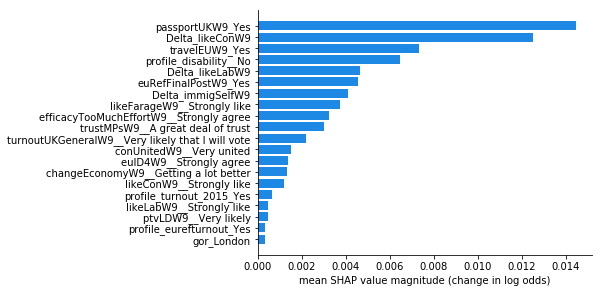

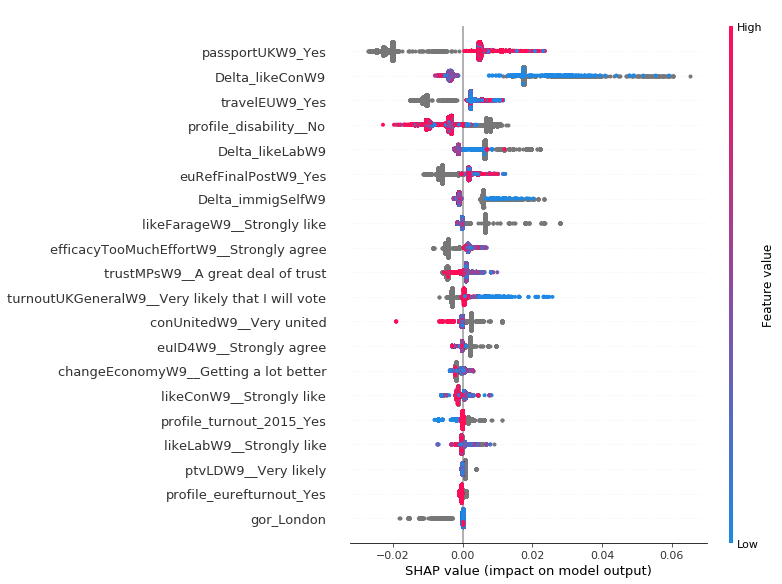

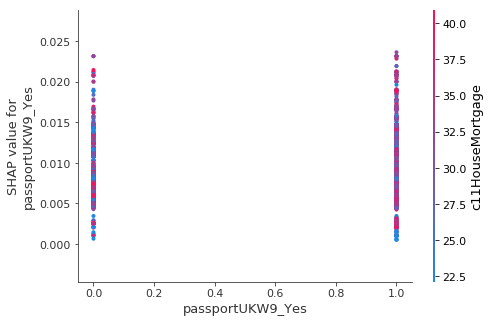

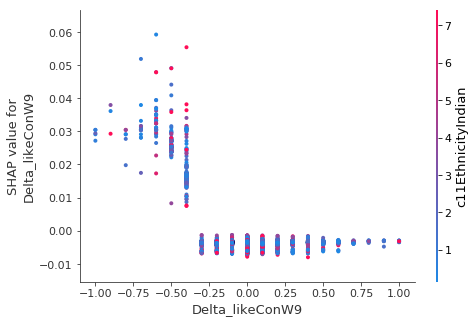

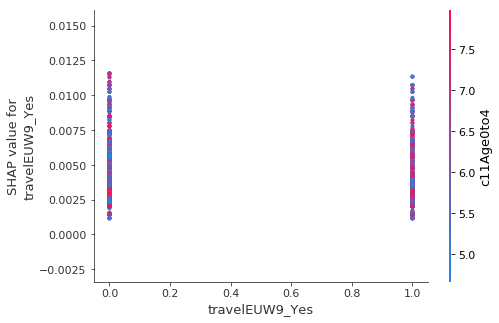

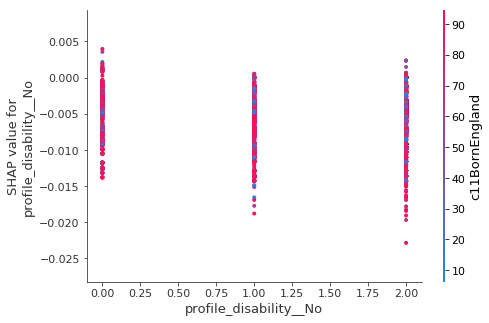

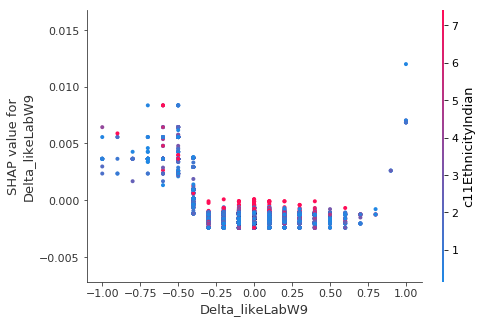

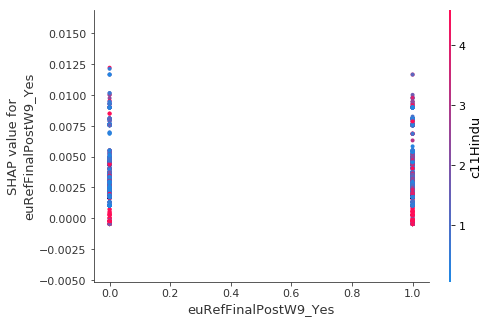

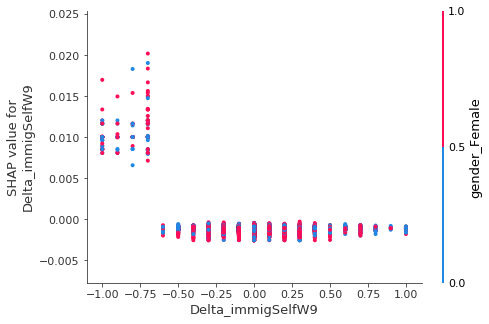

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


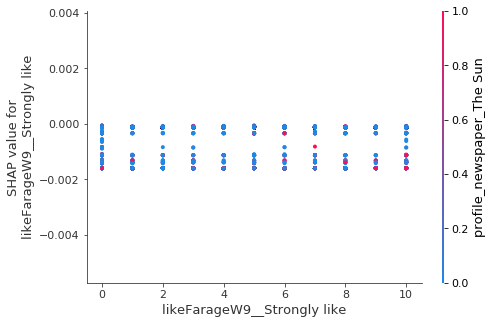

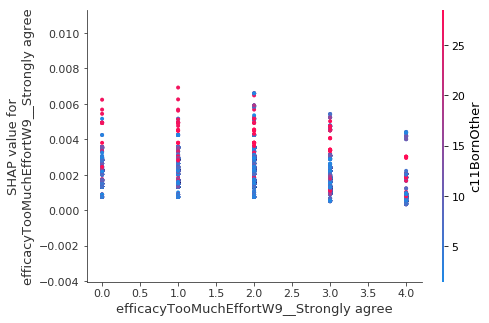

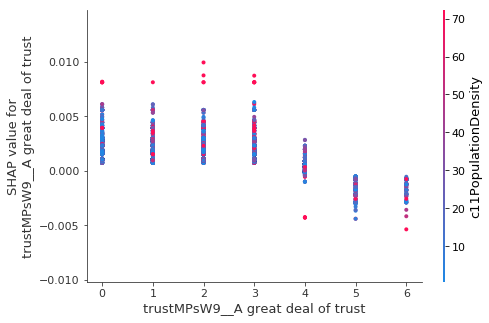

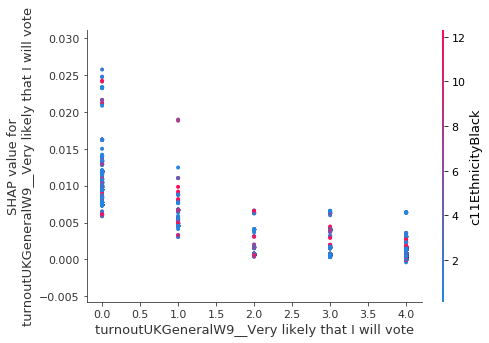

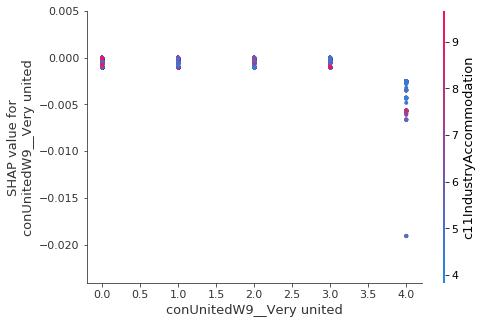

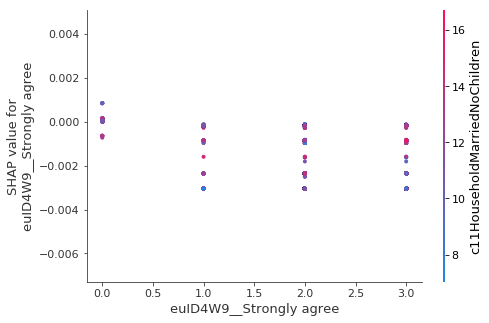

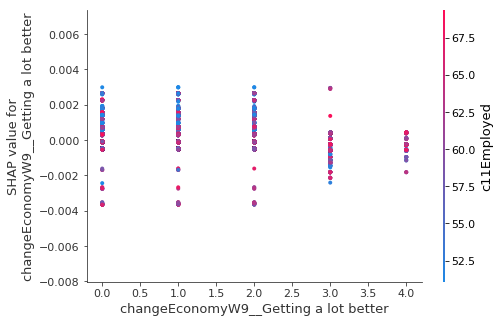

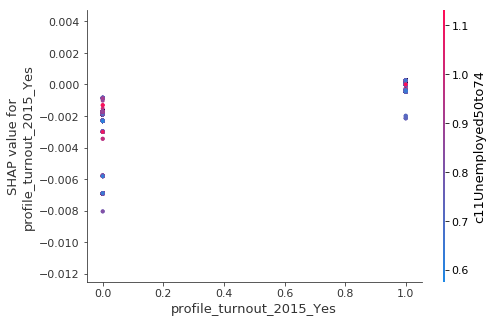

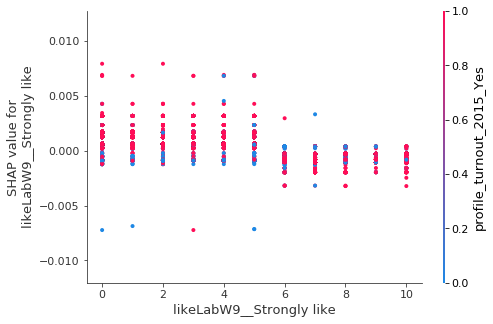

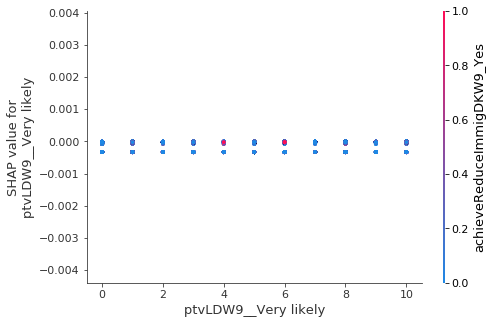

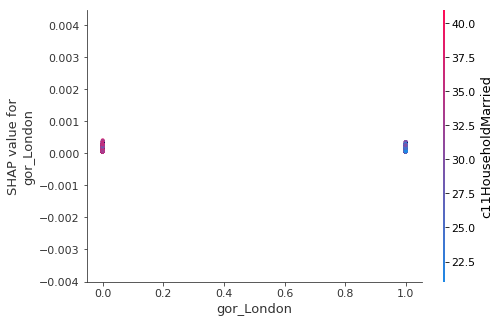

partyIdW10_No - none 10
missing vals in sample weights: 38306
[0]	validation_0-rmse:0.55236
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.535798
[2]	validation_0-rmse:0.520096
[3]	validation_0-rmse:0.505255
[4]	validation_0-rmse:0.491092
[5]	validation_0-rmse:0.477586
[6]	validation_0-rmse:0.464849
[7]	validation_0-rmse:0.452799
[8]	validation_0-rmse:0.441388
[9]	validation_0-rmse:0.430589
[10]	validation_0-rmse:0.420392
[11]	validation_0-rmse:0.410766
[12]	validation_0-rmse:0.401704
[13]	validation_0-rmse:0.393151
[14]	validation_0-rmse:0.385064
[15]	validation_0-rmse:0.377507
[16]	validation_0-rmse:0.370383
[17]	validation_0-rmse:0.363699
[18]	validation_0-rmse:0.35741
[19]	validation_0-rmse:0.351519
MSE: 0.12, MAE: 0.28, EV: 0.11, R2: -0.44


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


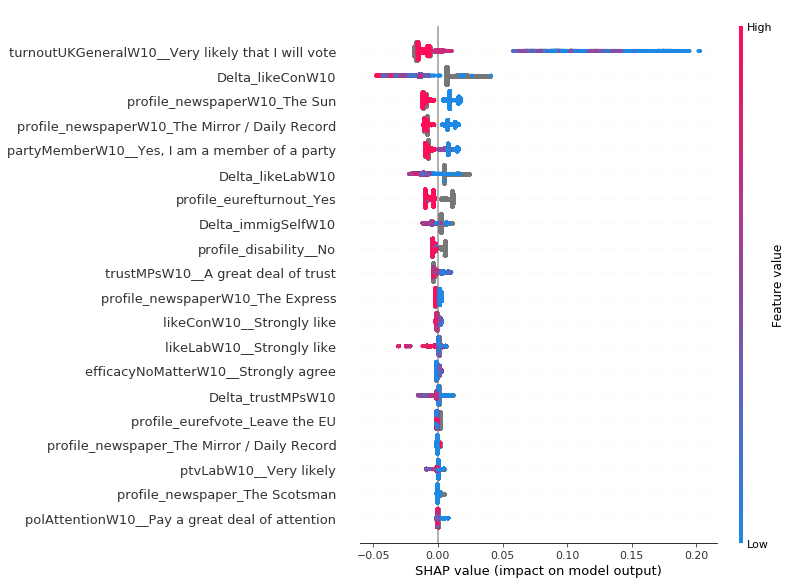

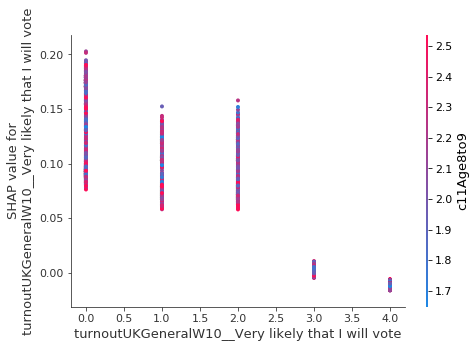

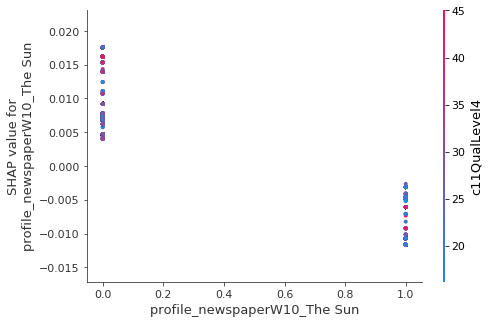

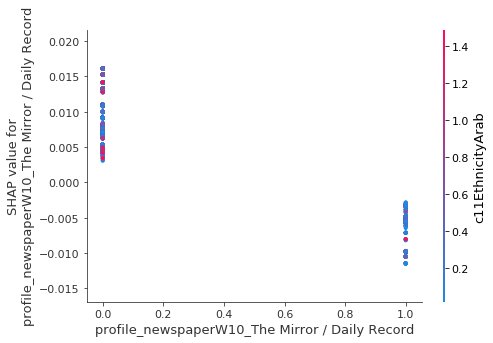

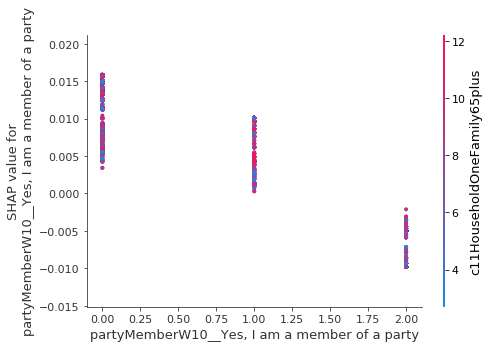

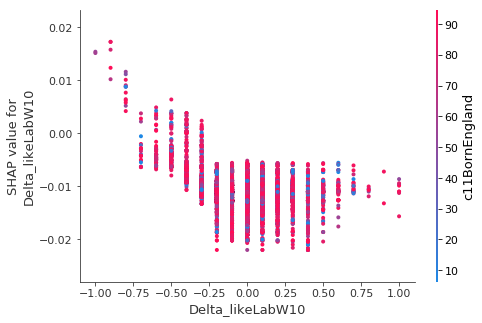

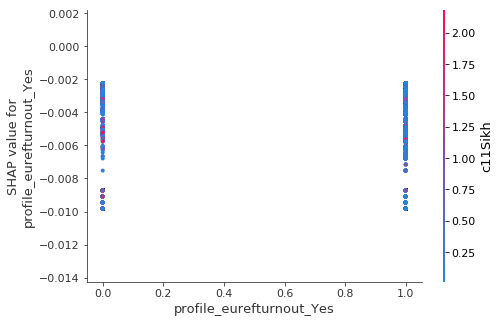

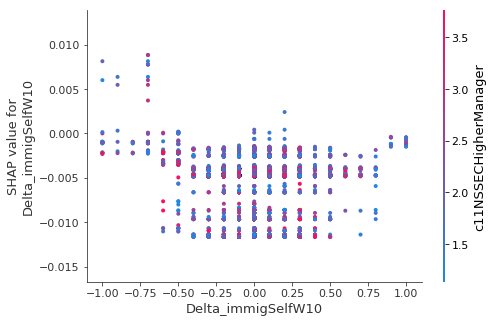

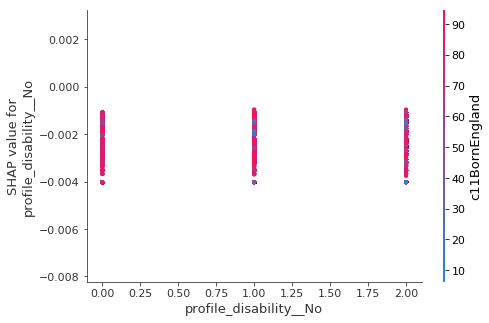

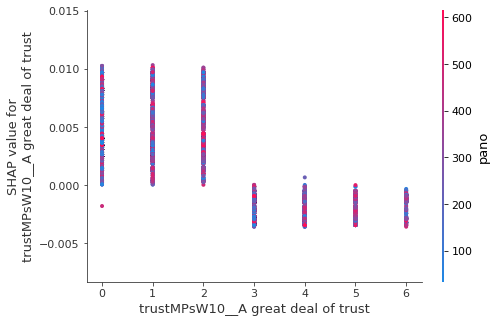

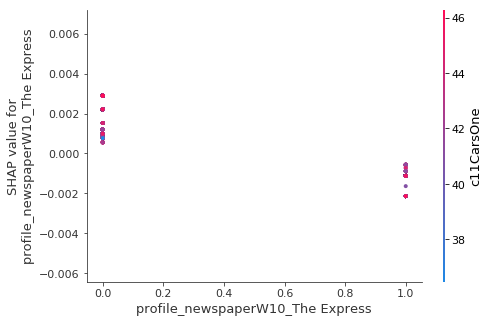

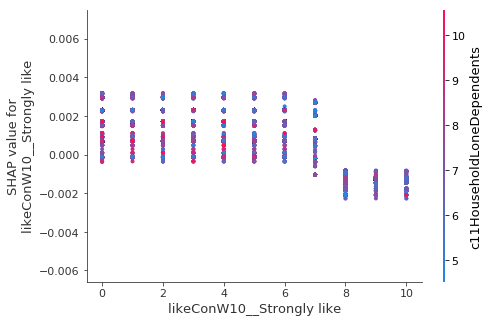

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


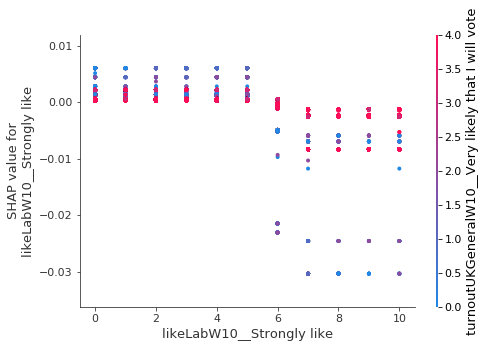

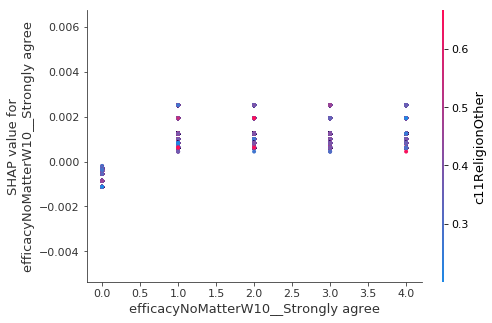

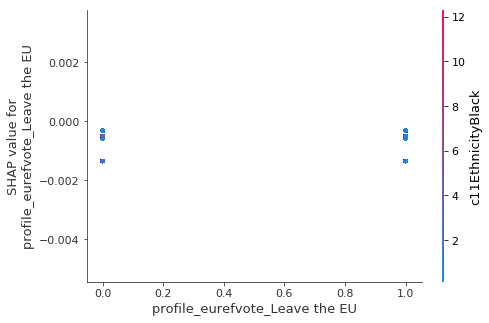

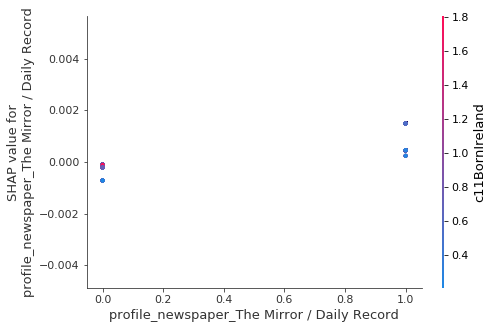

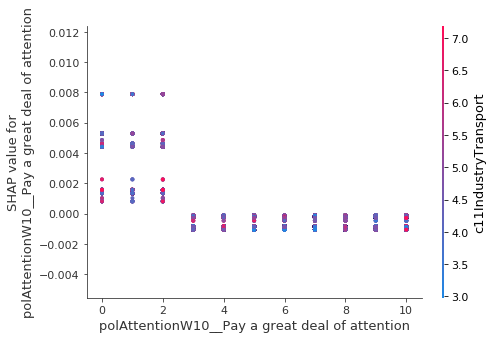

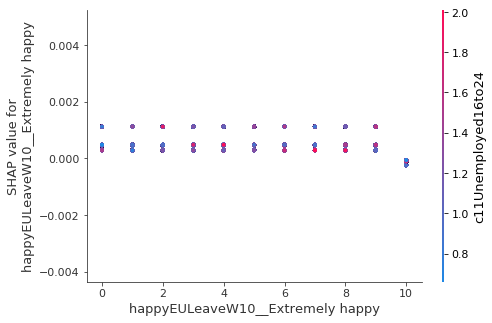

partyIdW11_No - none 11
missing vals in sample weights: 37611
[0]	validation_0-rmse:0.56089
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.54382
[2]	validation_0-rmse:0.527627
[3]	validation_0-rmse:0.512343
[4]	validation_0-rmse:0.497814
[5]	validation_0-rmse:0.483948
[6]	validation_0-rmse:0.470868
[7]	validation_0-rmse:0.458468
[8]	validation_0-rmse:0.446745
[9]	validation_0-rmse:0.435665
[10]	validation_0-rmse:0.42515
[11]	validation_0-rmse:0.415186
[12]	validation_0-rmse:0.405859
[13]	validation_0-rmse:0.396975
[14]	validation_0-rmse:0.388681
[15]	validation_0-rmse:0.380864
[16]	validation_0-rmse:0.373473
[17]	validation_0-rmse:0.366487
[18]	validation_0-rmse:0.359983
[19]	validation_0-rmse:0.353917
MSE: 0.13, MAE: 0.28, EV: 0.08, R2: -0.54


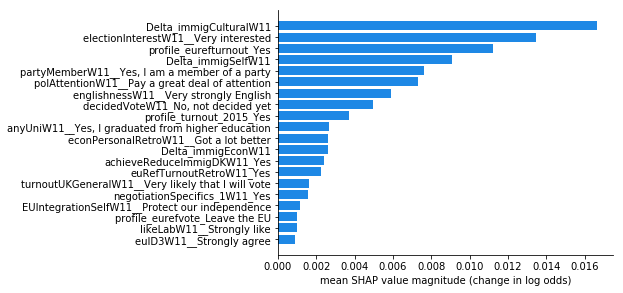

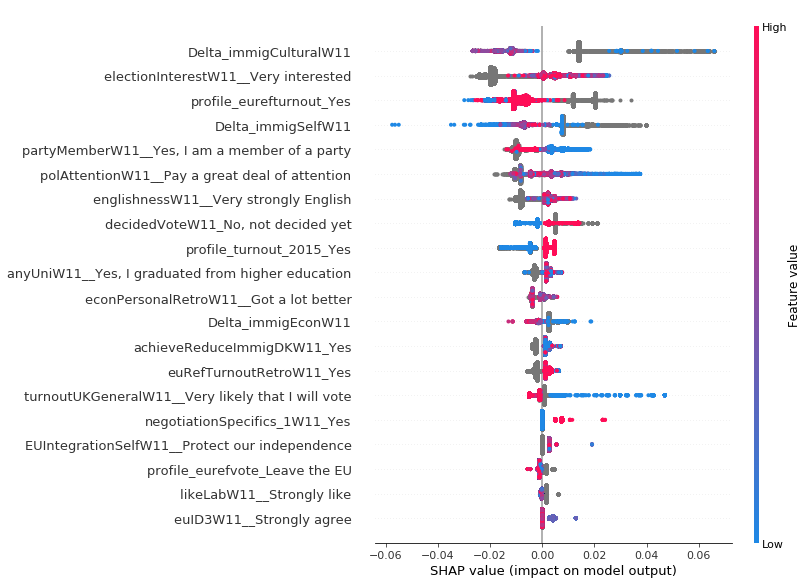

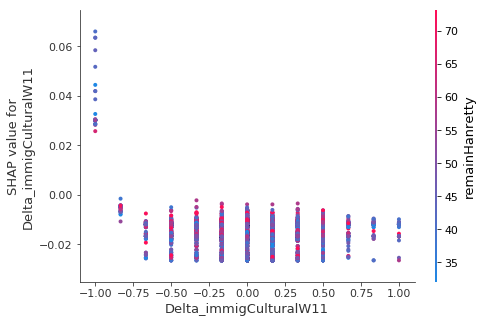

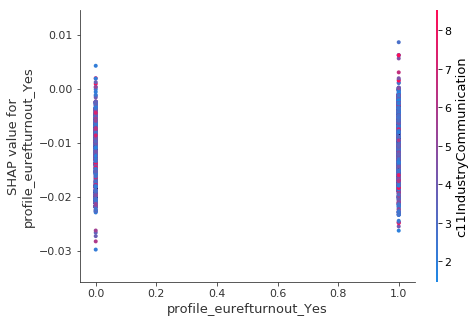

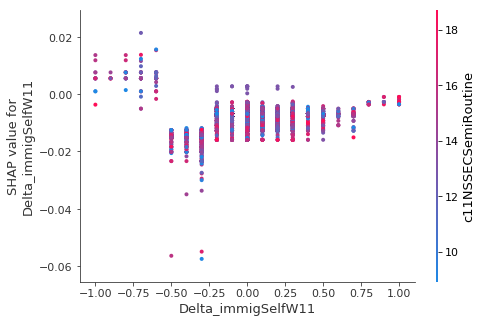

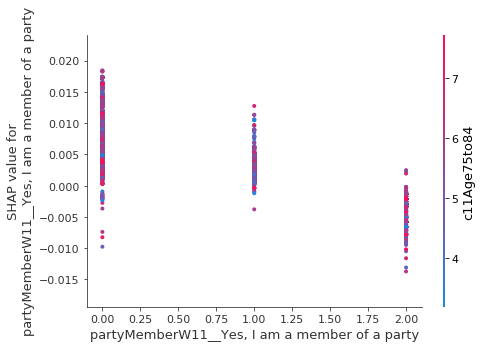

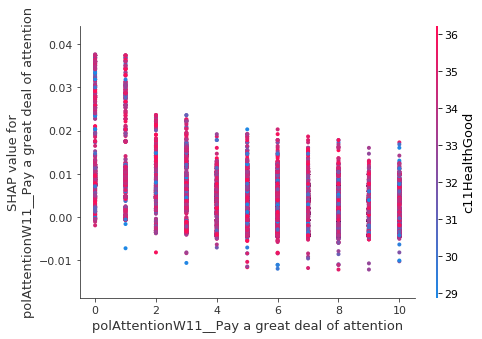

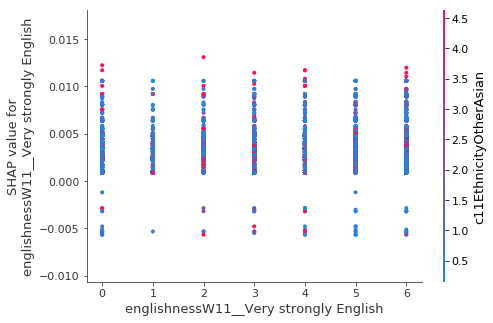

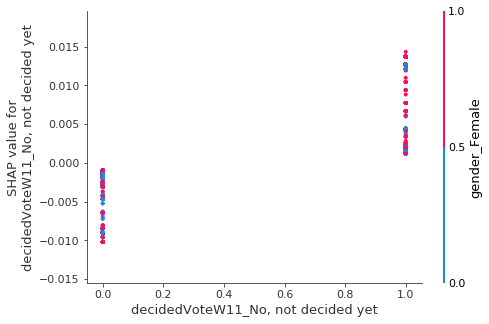

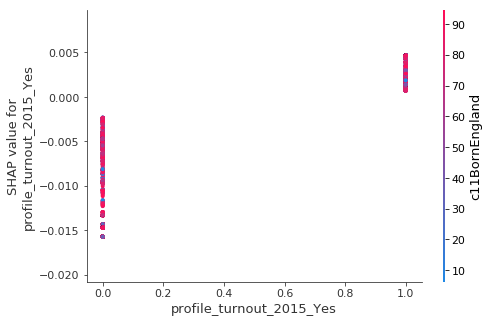

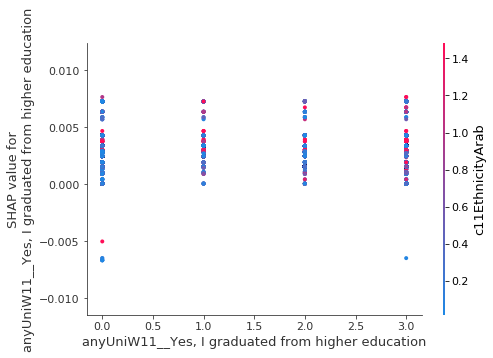

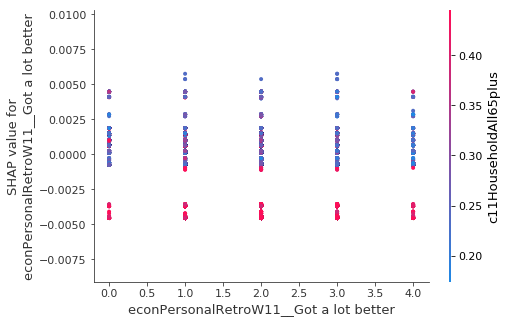

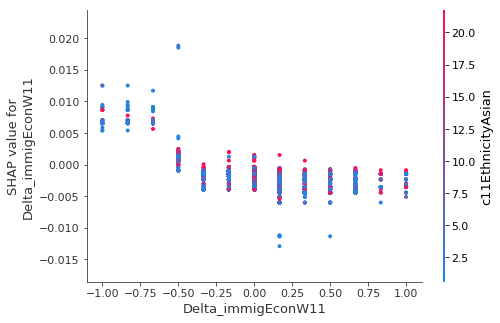

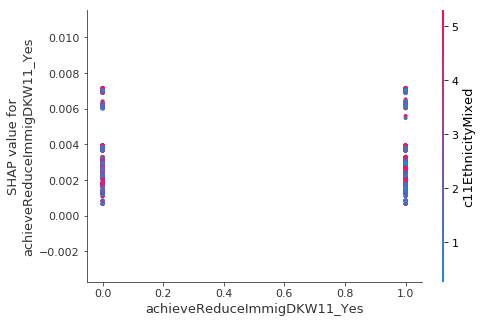

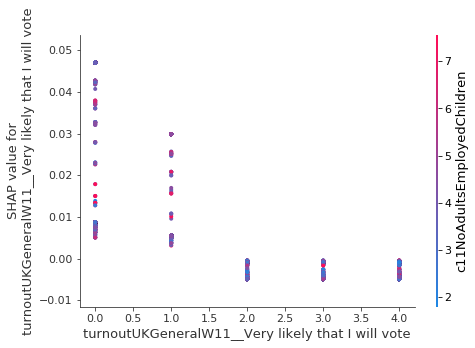

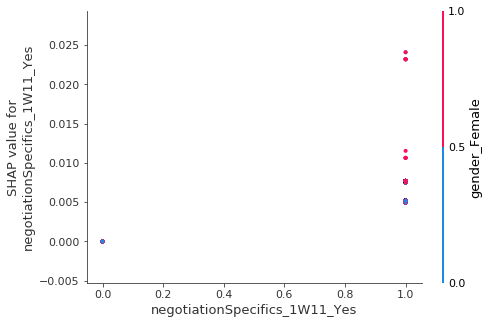

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


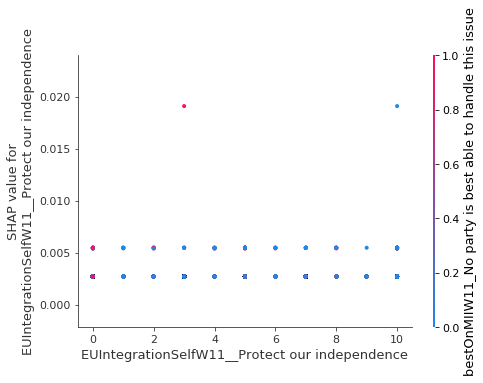

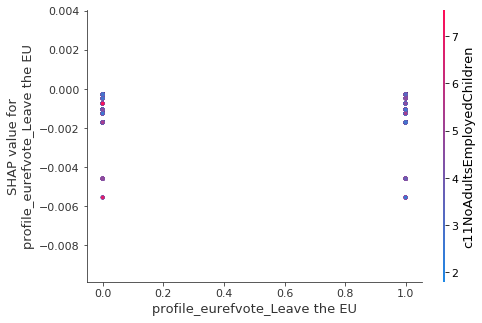

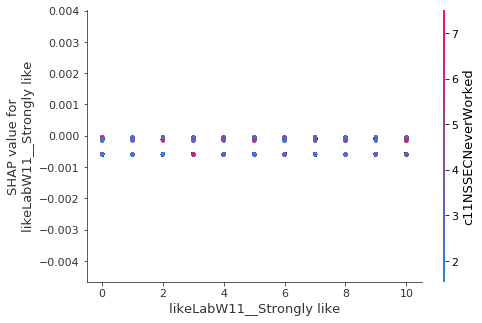

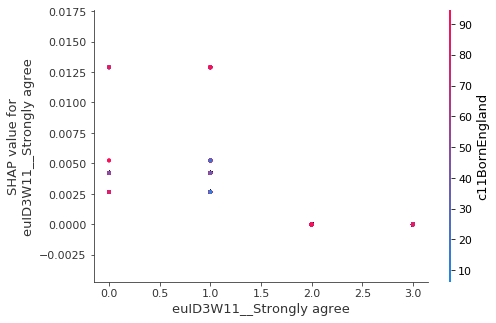

partyIdW12_No - none 12
missing vals in sample weights: 34161
[0]	validation_0-rmse:0.543289
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.527034
[2]	validation_0-rmse:0.51159
[3]	validation_0-rmse:0.496998
[4]	validation_0-rmse:0.483132
[5]	validation_0-rmse:0.469971
[6]	validation_0-rmse:0.457543
[7]	validation_0-rmse:0.445651
[8]	validation_0-rmse:0.434359
[9]	validation_0-rmse:0.423748
[10]	validation_0-rmse:0.413671
[11]	validation_0-rmse:0.404141
[12]	validation_0-rmse:0.395241
[13]	validation_0-rmse:0.386755
[14]	validation_0-rmse:0.378769
[15]	validation_0-rmse:0.371331
[16]	validation_0-rmse:0.364367
[17]	validation_0-rmse:0.35772
[18]	validation_0-rmse:0.351502
[19]	validation_0-rmse:0.345624
MSE: 0.12, MAE: 0.28, EV: 0.06, R2: -0.53


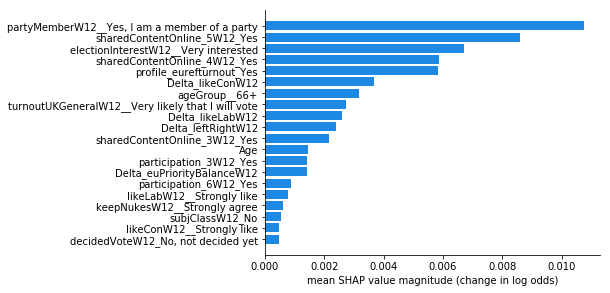

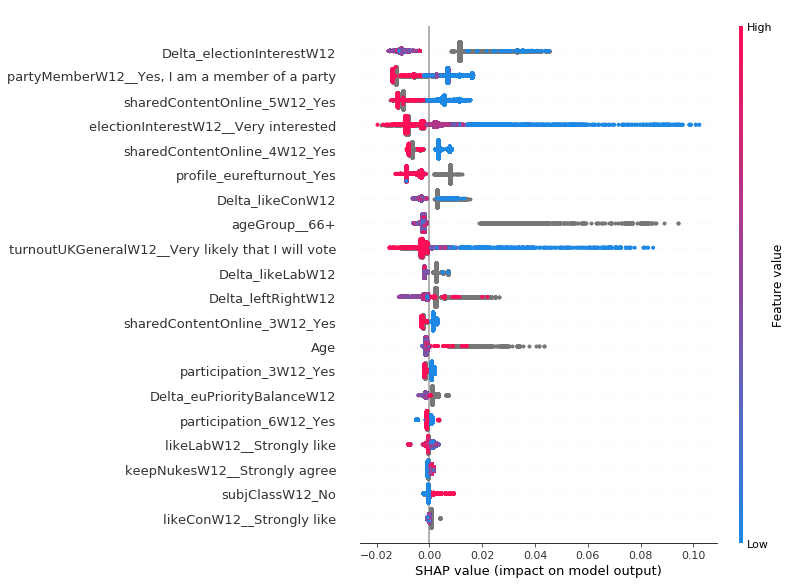

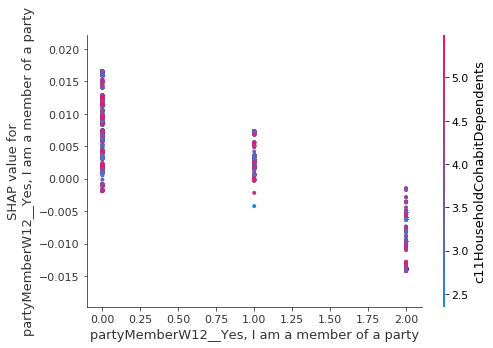

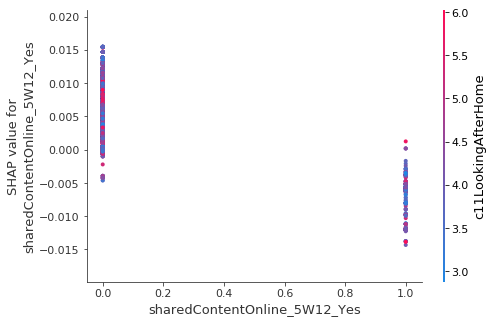

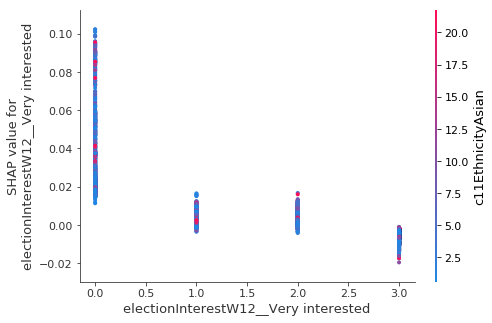

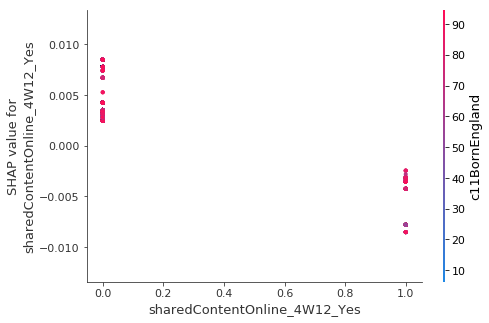

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


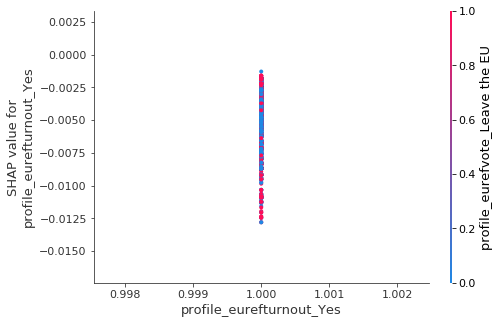

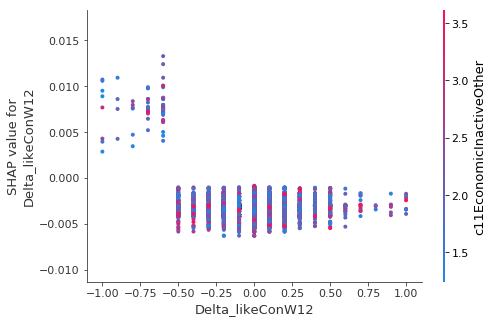

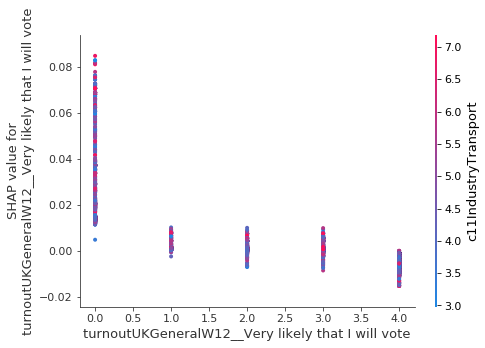

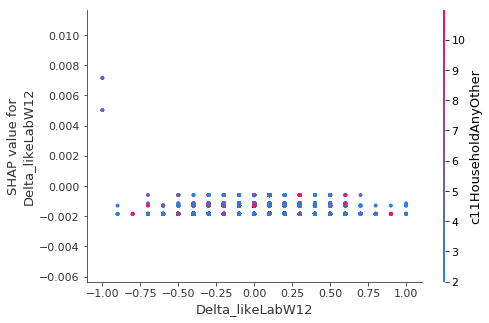

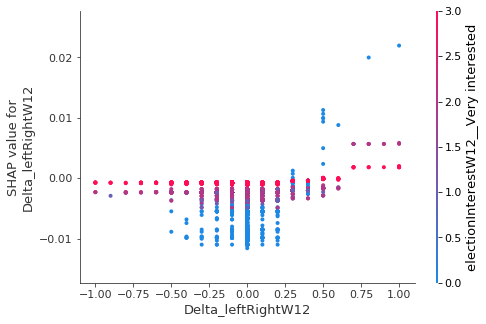

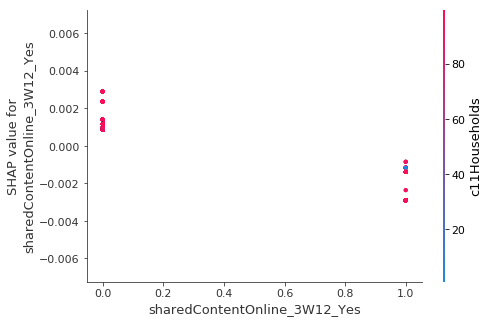

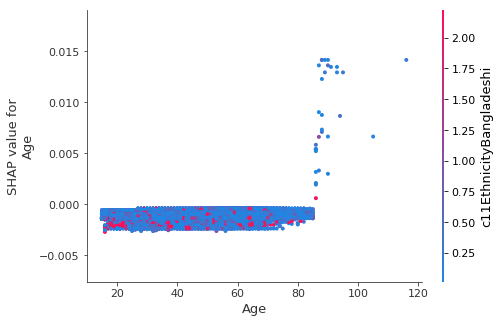

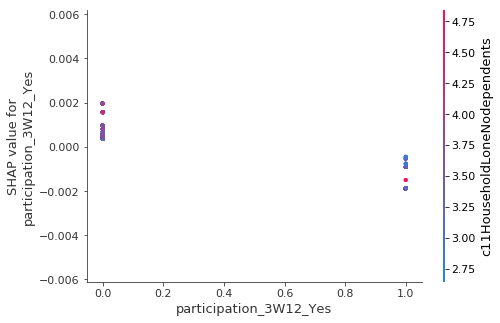

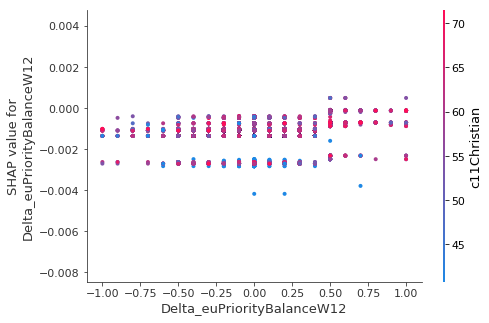

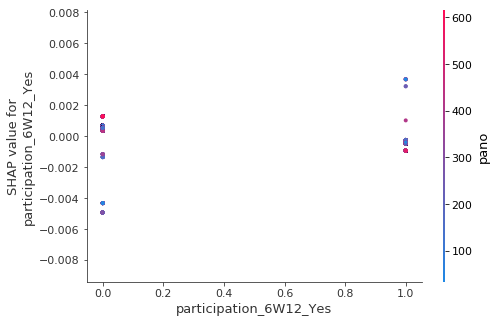

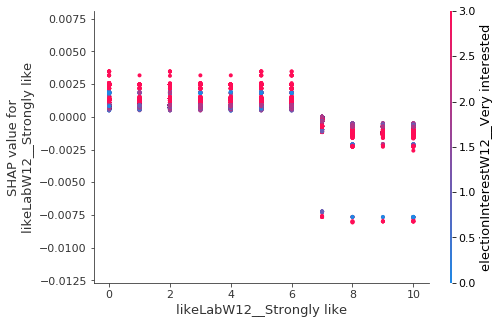

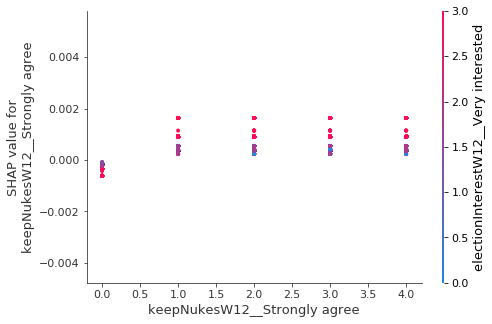

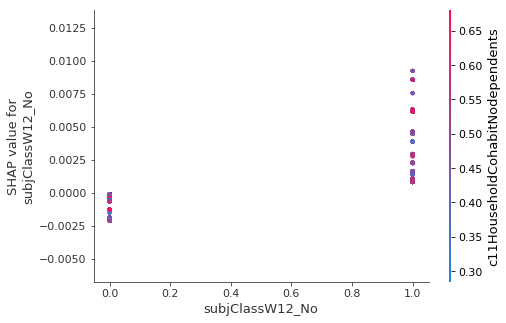

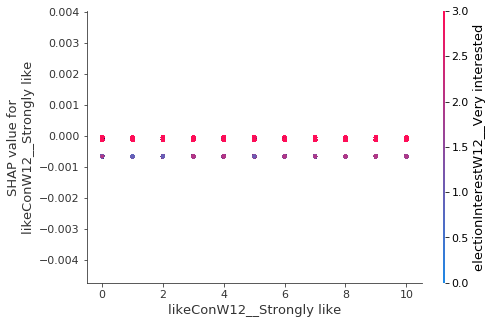

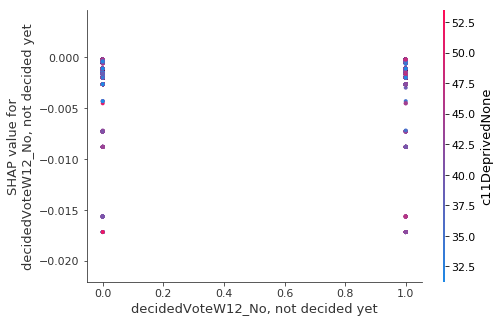

partyIdW13_No - none 13
missing vals in sample weights: 37429
[0]	validation_0-rmse:0.559025
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.541278
[2]	validation_0-rmse:0.524389
[3]	validation_0-rmse:0.508313
[4]	validation_0-rmse:0.493036
[5]	validation_0-rmse:0.478536
[6]	validation_0-rmse:0.464828
[7]	validation_0-rmse:0.451887
[8]	validation_0-rmse:0.43955
[9]	validation_0-rmse:0.42789
[10]	validation_0-rmse:0.416765
[11]	validation_0-rmse:0.406302
[12]	validation_0-rmse:0.396368
[13]	validation_0-rmse:0.387106
[14]	validation_0-rmse:0.378332
[15]	validation_0-rmse:0.370027
[16]	validation_0-rmse:0.362355
[17]	validation_0-rmse:0.355036
[18]	validation_0-rmse:0.348081
[19]	validation_0-rmse:0.341561
MSE: 0.12, MAE: 0.27, EV: 0.08, R2: -0.61


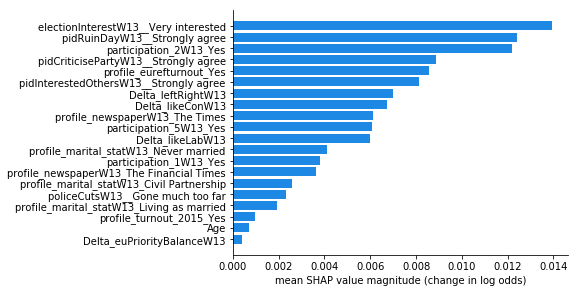

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


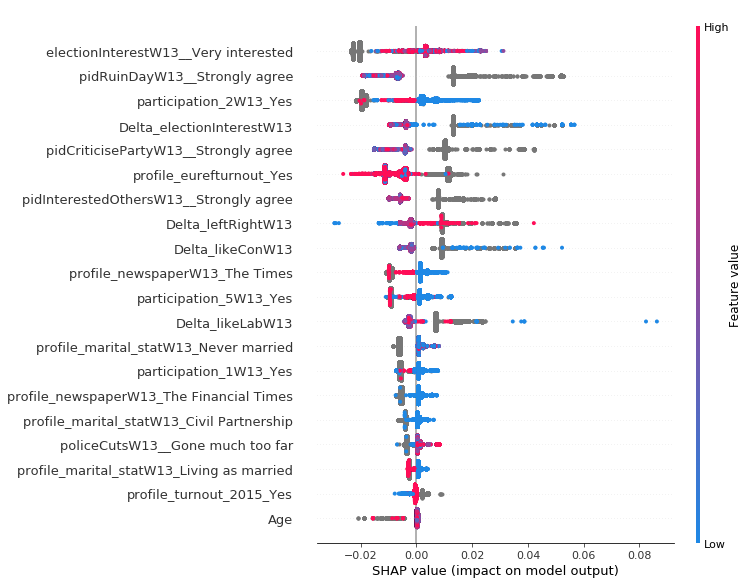

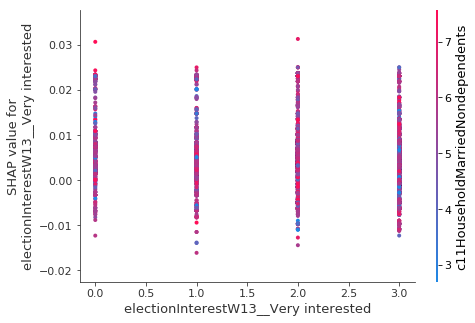

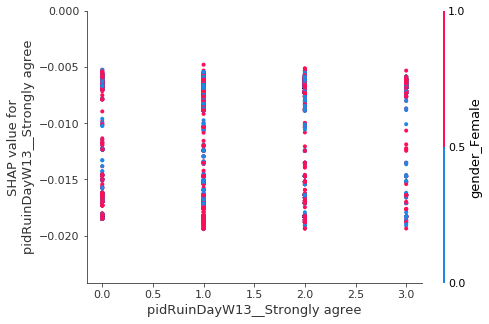

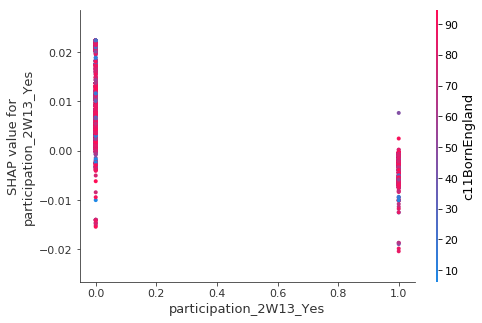

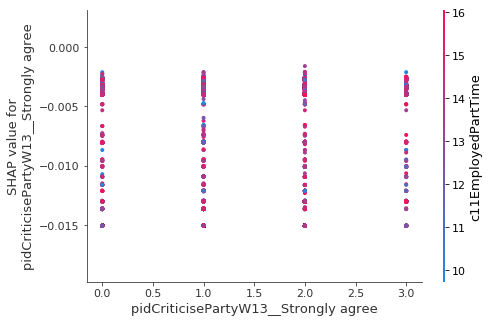

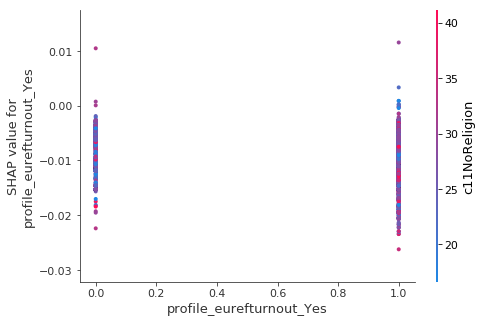

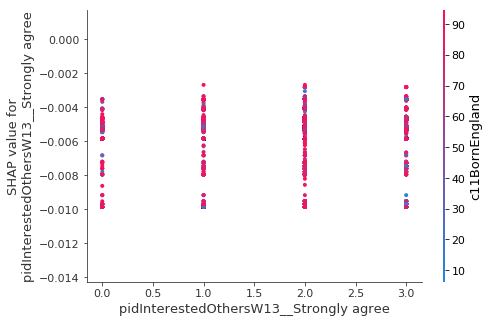

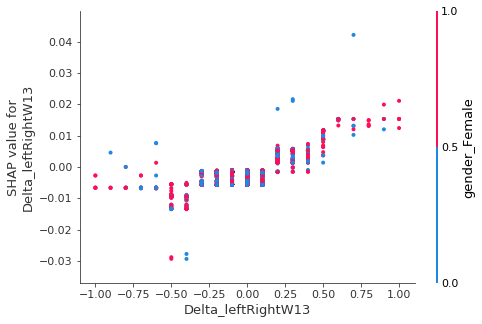

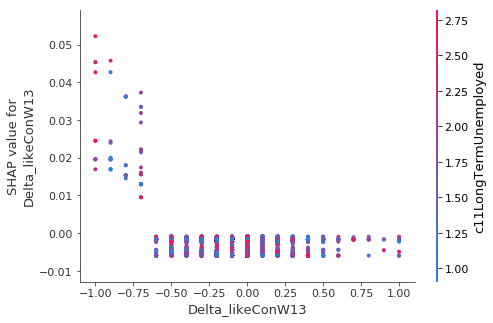

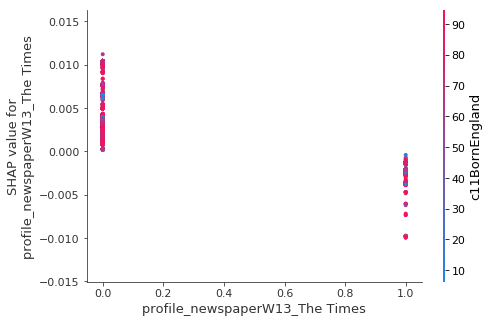

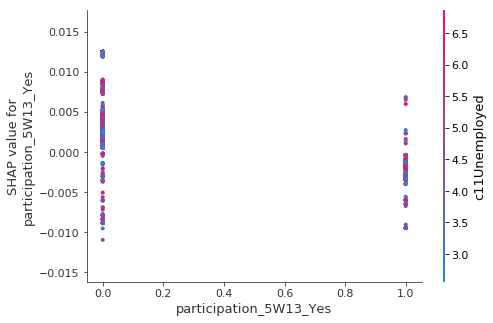

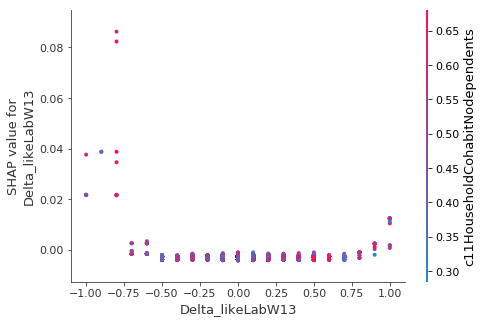

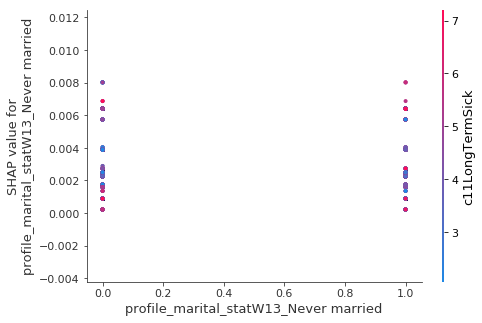

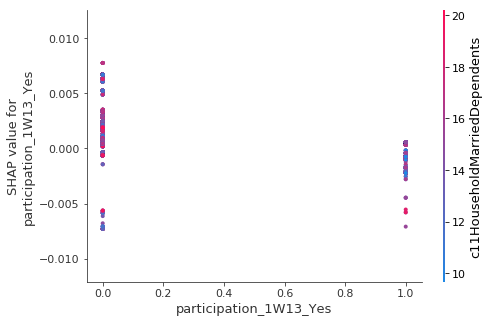

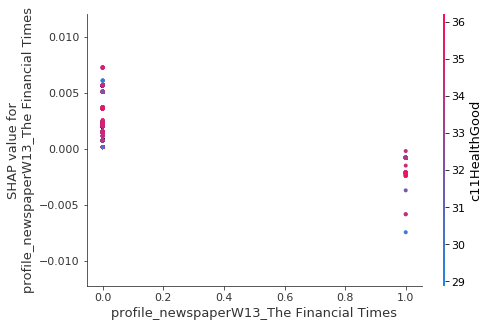

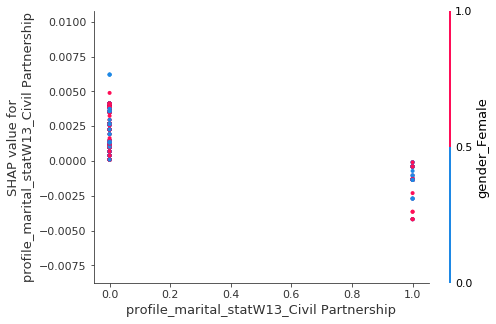

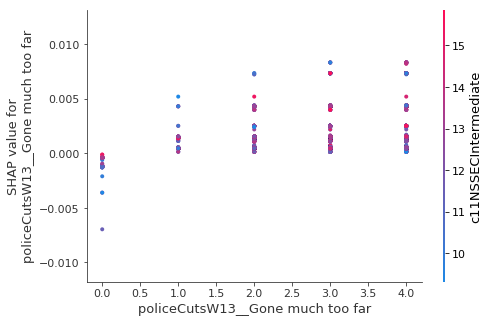

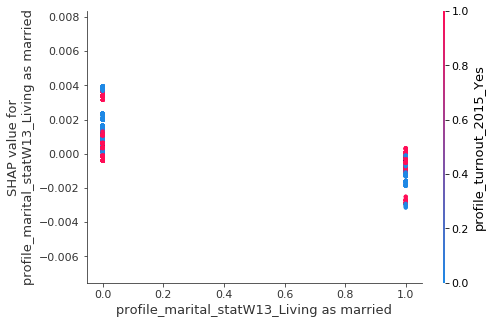

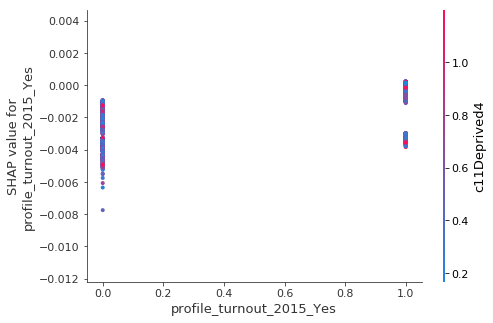

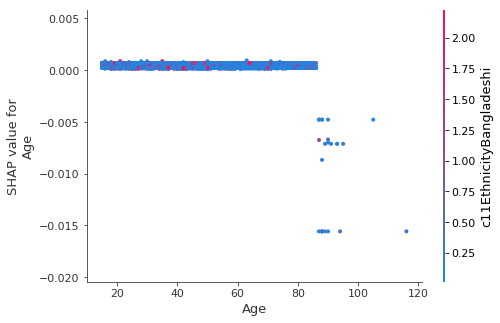

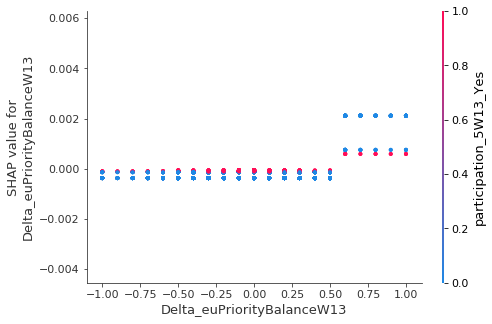

In [32]:
# for target_var,base_var in zip(var_list,base_list):
for target_var in var_list:
    wave_no = int( re.search( 'W(\d+)($|_)', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]    
    print( target_var, wave_no )  
    # mask = BES_reduced_with_na[target_var].notnull()
    mask = party_id_none_delta[target_var].notnull()
    # target = BES_reduced_with_na[target_var][mask]
    target = party_id_none_delta[target_var][mask]
    
    
#     mask = immigDiff[target_var].notnull()
    if sum(mask)<100:
        continue
#     target = immigDiff[target_var][mask]
    
#     train  = pd.concat(BES_reduced_with_na[mask]
    train = pd.concat( [ BES_reduced_with_na[mask] , immigDiff[mask] ] , axis=1 )
    # drop variables from other waves
    other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9-]|$)"
    train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )       
    
    for var_stub in var_stub_list:
        train = train.drop([x for x in train.columns if var_stub in x], axis=1)    


    sample_weights = weights[weight_var][mask]
    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())

    output_subfolder = BES_output_folder + "xgboost_"+Treatment + os.sep + target_var.replace(">","") + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


    ############################

    alg = XGBRegressor(
     learning_rate =0.04,
     n_estimators= 20,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.75,
     colsample_bytree=0.9,
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=27)

    # split data into train and test sets
    # fit, validate and find overfitting limit
    seed = 7
    test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



    eval_set = [(X_test, y_test)]

    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)

    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

    ####################################
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose = True, sample_weight = sample_weights)




    shap_values = shap.TreeExplainer(alg).shap_values(train);


    #################################
    threshold = .1
    min_features = 20
    global_shap_vals = np.abs(shap_values).mean(0)[:-1]
    n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
    if n_top_features <min_features:
        n_top_features = min_features



    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    fig.savefig( output_subfolder + "summary_plot" + ".png", bbox_inches='tight' )



    ##################
    count = 0
    for name in train.columns[inds[::-1]]:
        fig = plt.figure(figsize = (16,10))    
        shap.dependence_plot(name, shap_values, train)
        fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_")[0:30] + ".png", bbox_inches='tight')
        count = count + 1

In [ ]:
# likeCon, likeLab, pid???, decidedVote, infoSource???, leftRight, ptv???, partyMember, trustMPs, electionInterest
# dutyToVote2

In [37]:
immigDiff.notnull().sum()

Delta_ptvLabW2      6740
Delta_ptvLabW3     11993
Delta_ptvLabW4     11806
Delta_ptvLabW5     14108
Delta_ptvLabW6     14070
Delta_ptvLabW7     10593
Delta_ptvLabW8         4
Delta_ptvLabW9      6543
Delta_ptvLabW10    19380
Delta_ptvLabW11    21990
Delta_ptvLabW12     6320
Delta_ptvLabW13     6589
dtype: int64

In [11]:
import gc
gc.collect()

0